Group 3
- BANERJEE, Hiya
- EL-HAGE HAMMOUD, Samer
- ESPEDAL, Terje
- PUNRATTANAPONGS, Jitrayu
- STEPHENS, Allison
- XUE, Rui

# Introduction

Over the years, climate change has become a growing issue. The most alarming factor of climate change is that it is already in effect. From rising temperatures and sea levels to an increase in wildfires and droughts, the direct consequence on the human population is a rising concern which requires the world's immediate attention.

The past decade has observed a boom in social media platforms. Social media platforms have enabled individuals to express their opinion on topics of their choice. This individual expression has formed a huge unstructured database containing messages, statuses, chats, and news feeds which can then be tapped into to understand the general sentiment towards a specific topic.

## Problem Definition

For this project, we will be analyzing tweets from Twitter that are associated with climate change. Twitter was chosen because it is a huge source of information with an average of 330 million monthly active users. The Twitter data will be used to gain a better insight into people's perception of the ongoing crisis. Furthermore, it will be used to assess if general perception of climate change has witnessed a change over time.

The **goals** of the project are:
1. Performing sentiment analysis to understand the trend in climate change awareness over a duration of time.
2. Performing sentiment analysis to label climate change tweets as either positive, negative, or neutral in order to better understand the general sentiment towards climate change

## About the Dataset

Source of the dataset:
* [Kaggle: Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset)
* [Twitter API](https://developer.twitter.com/en/docs)

# Setup

First we need to load libraries and set up the environment.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import re
import json
import regex
import emoji
import string
import requests
import numpy as np
import pandas as pd
import missingno as msno
#from pandarallel import pandarallel


# Data Viz
import chart_studio
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import chart_studio.tools as tls
import chart_studio.plotly as py

# NLP
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from wordcloud import STOPWORDS

# set stopwords
stopwords = set(STOPWORDS)


# Matplotilb setup
mpl.rc('axes', labelsize= 14)
mpl.rc('xtick', labelsize= 12)
mpl.rc('ytick', labelsize= 12)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
# set project DIR
from pathlib import Path
PROJECT_DIR = os.getcwd()
# PROJECT_DIR = Path('G:/.shortcut-targets-by-id/1iC8ibnDz4WD8et_buhRAsJefsX2g5xDA/ML-with-Python/')
PROJECT_DIR

'/Users/mahora65/Desktop/ML-group'

In [3]:
# install twarc
try:
    import twarc
except ImportError:
    from pip._internal import main as pip
    pip(['install', 'twarc',])
    import twarc

In [4]:
# install tweepy
try:
    import tweepy
except ImportError:
    from pip._internal import main as pip
    pip(['install', 'tweepy==4.5.0',])
    import tweepy

In [5]:
# Downloading the library and downloading nltk-files
!pip install geograpy3
!gepgrapy-nltk

zsh:1: command not found: gepgrapy-nltk


# Load the data

In this project we will use both *labelled data* from Kaggle and *unlabelled data* which we get from Twitter API.

## Labelled Data

> The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo.

This dataset aggregates tweets pertaining to climate change collected between 27 Apr 2015 and 21 Feb 2018. In total, 43943 tweets were annotated. Each tweet is labelled independently by 3 reviewers. This dataset only contains tweets that all 3 reviewers agreed on (the rest were discarded).

Each tweet is labelled as one of the following classes:
* `2` (News): the tweet links to factual news about climate change.
* `1` (Pro): the tweet supports the belief of man-made climate change.
* `0` (Neutral): the tweet neither supports nor refutes the belief of man-made climate change.
* `-1` (Anti): the tweet does not believe in man-made climate change

Source: [Kaggle: Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset)

Size of Dataset: 43943 x 3

Attributes of the dataset:
* `sentiment`: the sentiment of the tweet.
* `message`: the text of the tweet.
* `tweet_id`: unique identifier for each tweet.

In [6]:
# Load labelled dataset

tweets_sentiment = pd.read_csv(os.path.join(PROJECT_DIR, 'data/labeled/twitter_sentiment_data.csv'), skiprows=1, names=['sentiment', 'message', 'id'])
tweets_sentiment.head()

sentiment                                            message  \
0         -1  @tiniebeany climate change is an interesting h...   
1          1  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          1  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          1  RT @Mick_Fanning: Just watched this amazing do...   
4          2  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

                   id  
0  792927353886371840  
1  793124211518832641  
2  793124402388832256  
3  793124635873275904  
4  793125156185137153

We will try using Twitter API to get more *meta data* about each tweet.

In [7]:
# Import twarc expansions to get all tweet fields available
from twarc.expansions import (
    EXPANSIONS,
    TWEET_FIELDS,
    USER_FIELDS,
    MEDIA_FIELDS,
    POLL_FIELDS,
    PLACE_FIELDS
)
import tweepy
from datetime import datetime

## Authentication Twitter
client = tweepy.Client(bearer_token="AAAAAAAAAAAAAAAAAAAAAErJZQEAAAAArFwJ3Dd866hFBzWWGAF01%2BeCSjE%3DJdc5lPpIaRTGBIIbh9OS8zBEQwbciNlSBdtqQWNCs0Cl1Gogwh",
                       wait_on_rate_limit=True)

In [8]:
# Get wanted metadata for tweet ids. Max 100 per chunk since Twitter limit
def get_metadata_for_tweets(df, id_col, chunk_n=100, tweet_fields=TWEET_FIELDS,
                            expansions=EXPANSIONS, user_fields=USER_FIELDS,
                            poll_fields=POLL_FIELDS, place_fields=PLACE_FIELDS,
                            media_fields=MEDIA_FIELDS):
    """
    Gets metadata from the twitter API for a dataframe containing at minimum a
    list of tweet ids. By default divides dataframe into chunks of 100 which
    is max query for Twitter API. Accepts tweet_field and tweet_expansions
    as parameters. See Twitter API for a list of accepted fields and expansions.
    https://developer.twitter.com/en/docs/twitter-api/fields
    https://developer.twitter.com/en/docs/twitter-api/expansions

    param: df Pandas dataframe containing at minimum tweetids
    param: id_col Column containing tweet ids
    param: chunk_n Number of rows per chunk to divide dataframe into.
           by default 100. This corresponds to the max accepted by Twitter API
    param: tweet_fields List of extra fields to get from Twitter API
    param: expansions List of expansions to get from Twitter API
    """
    chunks = [df[i:i+chunk_n].copy() for i in range(0,df.shape[0],chunk_n)]
    joined_dfs = []

    for chunk in chunks:
        # Join ids by "," since query needs to be a string of ids separated by ","
        ids = ",".join(chunk[id_col].astype("str").values)

        response = client.get_tweets(ids, tweet_fields=tweet_fields, expansions=expansions,
                                     media_fields=media_fields, user_fields=user_fields,
                                     poll_fields=poll_fields, place_fields=place_fields)
        # Expand Tweepy response object into dataframe for easier merging
        tweets = pd.DataFrame(response.data)
        joined_dfs.append(chunk.merge(tweets, on="id", how="left"))

    return pd.concat(joined_dfs).reset_index(drop=True)

In [9]:
def update_tweet_df_with_meta(df, id_col, save=True):
    """
    Updates a pandas dataframe containing a column of tweet ids with all metadata
    available for every tweet. By default saves to a CSV file, but can be overidden

    param: df Dataframe containing tweet ids
    param: id_col Name of column containing tweet ids
    returns: Pandas dataframe updated with metadata for tweets
    """
    now = datetime.now()
    timestamp_string = now.strftime("%m-%d-%Y_%H:%M:%S")

    df_wtih_meta = get_metadata_for_tweets(df, id_col)
    df_with_meta = df_wtih_meta.reset_index(drop=True)

    if save:
        df_with_meta.to_csv(os.path.join(PROJECT_DIR,f"/data/labeled/tweets_with_meta_{timestamp_string}.csv"))

    return df_with_meta

In [10]:
# Get metadata for tweets and save to CSV
# labelled_with_meta = update_tweet_df_with_meta(tweets_sentiment, "id", save=False)

In [11]:
# Read past run data to save time
labelled_with_meta = pd.read_csv(os.path.join(PROJECT_DIR,'data/labeled/tweets_with_meta_updated.csv'))
labelled_with_meta.head()

/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_1816/3393534776.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  labelled_with_meta = pd.read_csv(os.path.join(PROJECT_DIR,'data/labeled/tweets_with_meta_updated.csv'))


Unnamed: 0  sentiment                                            message  \
0          0       -1.0  @tiniebeany climate change is an interesting h...   
1          1        1.0  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          2        1.0  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          3        1.0  RT @Mick_Fanning: Just watched this amazing do...   
4          4        2.0  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

             id                                context_annotations  \
0  7.929274e+17  [{'domain': {'id': '25', 'name': 'Events', 'de...   
1  7.931242e+17                                                NaN   
2  7.931244e+17                                                NaN   
3  7.931246e+17  [{'domain': {'id': '25', 'name': 'Events', 'de...   
4  7.931252e+17  [{'domain': {'id': '25', 'name': 'Events', 'de...   

                  created_at  \
0  2016-10-31 03:13:07+00:00   
1                        NaN   
2  2016-10-31 16:16:07+00:00   
3  2016-10-31 16:17:03+00:00   
4  2016-10-31 16:19:07+00:00   

                                            entities  in_reply_to_user_id  \
0  {'mentions': [{'start': 0, 'end': 11, 'usernam...          139956991.0   
1                                                NaN                  NaN   
2  {'annotations': [{'start': 10, 'end': 17, 'pro...                  NaN   
3  {'urls': [{'start': 114, 'end': 137, 'url': 'h...                  NaN   
4  {'annotations': [{'start': 13, 'end': 27, 'pro...                  NaN   

  lang possibly_sensitive                                     public_metrics  \
0   en              False  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
1  NaN                NaN                                                NaN   
2   en              False  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
3   en              False  {'retweet_count': 21, 'reply_count': 0, 'like_...   
4   en              False  {'retweet_count': 10, 'reply_count': 0, 'like_...   

                                   referenced_tweets               source  \
0  [<ReferencedTweet id=792925468081127424 type=r...  Twitter for Android   
1                                                NaN                  NaN   
2                                                NaN   Twitter Web Client   
3  [<ReferencedTweet id=793116439045701636 type=r...   Twitter Web Client   
4  [<ReferencedTweet id=793124743109087233 type=r...  Twitter for Android   

                                                text  geo withheld  
0  @tiniebeany climate change is an interesting h...  NaN      NaN  
1                                                NaN  NaN      NaN  
2  Fabulous! Leonardo #DiCaprio's film on #climat...  NaN      NaN  
3  RT @Mick_Fanning: Just watched this amazing do...  NaN      NaN  
4  RT @cnalive: Pranita Biswasi, a Lutheran from ...  NaN      NaN

some of the dataset such as `context annotation`, `entities`, and `public metrics` are still nested with list and dict. These columns contain values as a `str` we need to cast it into appropriate type and un-nest it accordingly.  

In [12]:
# Convert string to obj
from ast import literal_eval

nested_cols = ['context_annotations', 'entities', 'public_metrics']

# Cast columns into appropriate data types
for col in nested_cols:
    labelled_with_meta[col] = labelled_with_meta[col].apply(lambda x: literal_eval(x) if isinstance(x, str) else np.nan)

labelled_with_meta.head()

Unnamed: 0  sentiment                                            message  \
0          0       -1.0  @tiniebeany climate change is an interesting h...   
1          1        1.0  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          2        1.0  Fabulous! Leonardo #DiCaprio's film on #climat...   
3          3        1.0  RT @Mick_Fanning: Just watched this amazing do...   
4          4        2.0  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

             id                                context_annotations  \
0  7.929274e+17  [{'domain': {'id': '25', 'name': 'Events', 'de...   
1  7.931242e+17                                                NaN   
2  7.931244e+17                                                NaN   
3  7.931246e+17  [{'domain': {'id': '25', 'name': 'Events', 'de...   
4  7.931252e+17  [{'domain': {'id': '25', 'name': 'Events', 'de...   

                  created_at  \
0  2016-10-31 03:13:07+00:00   
1                        NaN   
2  2016-10-31 16:16:07+00:00   
3  2016-10-31 16:17:03+00:00   
4  2016-10-31 16:19:07+00:00   

                                            entities  in_reply_to_user_id  \
0  {'mentions': [{'start': 0, 'end': 11, 'usernam...          139956991.0   
1                                                NaN                  NaN   
2  {'annotations': [{'start': 10, 'end': 17, 'pro...                  NaN   
3  {'urls': [{'start': 114, 'end': 137, 'url': 'h...                  NaN   
4  {'annotations': [{'start': 13, 'end': 27, 'pro...                  NaN   

  lang possibly_sensitive                                     public_metrics  \
0   en              False  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
1  NaN                NaN                                                NaN   
2   en              False  {'retweet_count': 0, 'reply_count': 0, 'like_c...   
3   en              False  {'retweet_count': 21, 'reply_count': 0, 'like_...   
4   en              False  {'retweet_count': 10, 'reply_count': 0, 'like_...   

                                   referenced_tweets               source  \
0  [<ReferencedTweet id=792925468081127424 type=r...  Twitter for Android   
1                                                NaN                  NaN   
2                                                NaN   Twitter Web Client   
3  [<ReferencedTweet id=793116439045701636 type=r...   Twitter Web Client   
4  [<ReferencedTweet id=793124743109087233 type=r...  Twitter for Android   

                                                text  geo withheld  
0  @tiniebeany climate change is an interesting h...  NaN      NaN  
1                                                NaN  NaN      NaN  
2  Fabulous! Leonardo #DiCaprio's film on #climat...  NaN      NaN  
3  RT @Mick_Fanning: Just watched this amazing do...  NaN      NaN  
4  RT @cnalive: Pranita Biswasi, a Lutheran from ...  NaN      NaN

as `context_annotations` is a `List` type, we gotta decoded it manually.

In [13]:
# decode context_annotations
labelled_with_meta['context_annotations'] = labelled_with_meta.context_annotations.apply(lambda y: [x['entity']['name'] for x in y] if isinstance(y, list) else [])

However, the columns `entities` and `public_metrics` is `Dict` type, we can use `json_normalize()` to un-nested them.

In [14]:
for col in ['entities', 'public_metrics']:
    labelled_with_meta = labelled_with_meta.merge(pd.json_normalize(labelled_with_meta[col]), left_index= True, right_index= True).drop(columns=[col])

Now we can decoded un-nested columns

In [15]:
for key, value in {'mentions': 'username', 'hashtags': 'tag', 'urls': 'expanded_url'}.items():
    labelled_with_meta[key] = labelled_with_meta[key].apply(lambda y: [x[value] for x in y] if isinstance(y, list) else [])

In [16]:
labelled_with_meta.head(3)

Unnamed: 0  sentiment                                            message  \
0          0       -1.0  @tiniebeany climate change is an interesting h...   
1          1        1.0  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2          2        1.0  Fabulous! Leonardo #DiCaprio's film on #climat...   

             id                                context_annotations  \
0  7.929274e+17  [Extreme Weather + Climate Change, Discovery V...   
1  7.931242e+17                                                 []   
2  7.931244e+17                                                 []   

                  created_at  in_reply_to_user_id lang possibly_sensitive  \
0  2016-10-31 03:13:07+00:00          139956991.0   en              False   
1                        NaN                  NaN  NaN                NaN   
2  2016-10-31 16:16:07+00:00                  NaN   en              False   

                                   referenced_tweets  ... withheld  \
0  [<ReferencedTweet id=792925468081127424 type=r...  ...      NaN   
1                                                NaN  ...      NaN   
2                                                NaN  ...      NaN   

       mentions                                        annotations  \
0  [tiniebeany]                                                NaN   
1            []                                                NaN   
2     [YouTube]  [{'start': 10, 'end': 17, 'probability': 0.887...   

              hashtags                                               urls  \
0                   []                                                 []   
1                   []                                                 []   
2  [DiCaprio, climate]  [http://www.youtube.com/watch?v=90CkXVF-Q8M&sn...   

  cashtags retweet_count reply_count like_count  quote_count  
0      NaN           0.0         0.0        0.0          0.0  
1      NaN           NaN         NaN        NaN          NaN  
2      NaN           0.0         0.0        1.0          0.0  

[3 rows x 23 columns]

columns `referenced_tweets`, `Unnamed: 0`, `text`, and etc. are no use for us, we gonna drop it.

In [17]:
# drop referenced_tweets
labelled_with_meta = labelled_with_meta.drop(columns= ['referenced_tweets', 'Unnamed: 0', 'text', 'annotations', 'cashtags', 'geo', 'withheld'])

Next, we checking for a missing values.

<AxesSubplot:>

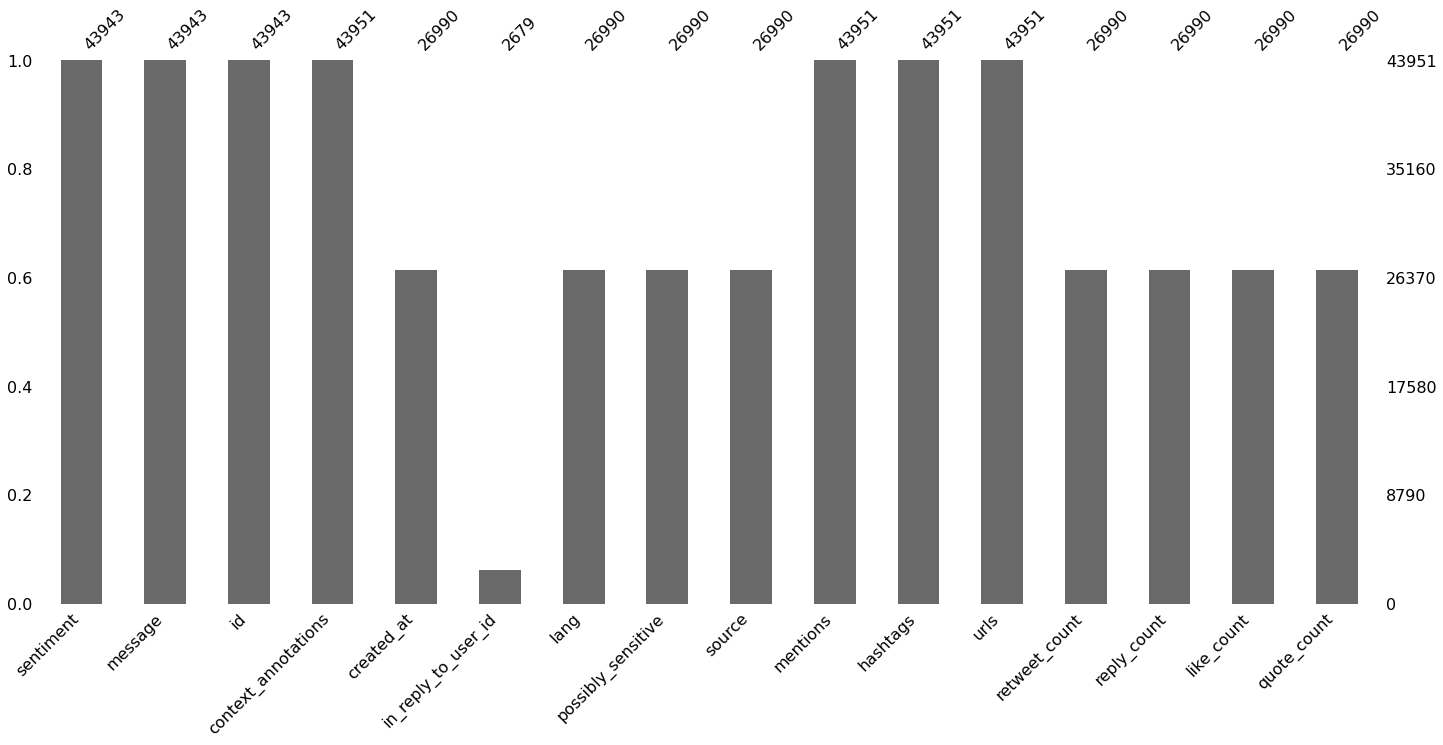

In [18]:
# missing value percentage
msno.bar(labelled_with_meta)

Since `sentiment` is our **target variable**. First, we gonna drop all the rows which missing it.

In [19]:
labelled_with_meta = labelled_with_meta.dropna(subset= ['sentiment'])

For column such as `in_reply_to_user_id`, we go create new column called `in_reply_to_user` to capture whether the tweet reply to user or not. 

In [20]:
import math
labelled_with_meta['in_reply_to_user'] = labelled_with_meta.in_reply_to_user_id.apply(lambda x: 0 if math.isnan(x) else 1)
labelled_with_meta.drop('in_reply_to_user_id', axis=1, inplace=True)

Now we will fill all the missing value with `mode()` of each columns.

In [21]:
dict_fill = {'retweet_count': 0,
             'reply_count': 0,
             'like_count': 0,
             'quote_count': 0,
             'possibly_sensitive': False,
             'source': 'Twitter for iPhone',
             'lang' : 'en',
             'created_at': '2016-11-16 19:10:03+00:00'
             }

for col, var in dict_fill.items():
    labelled_with_meta[col] = labelled_with_meta[col].fillna(var) 

<AxesSubplot:>

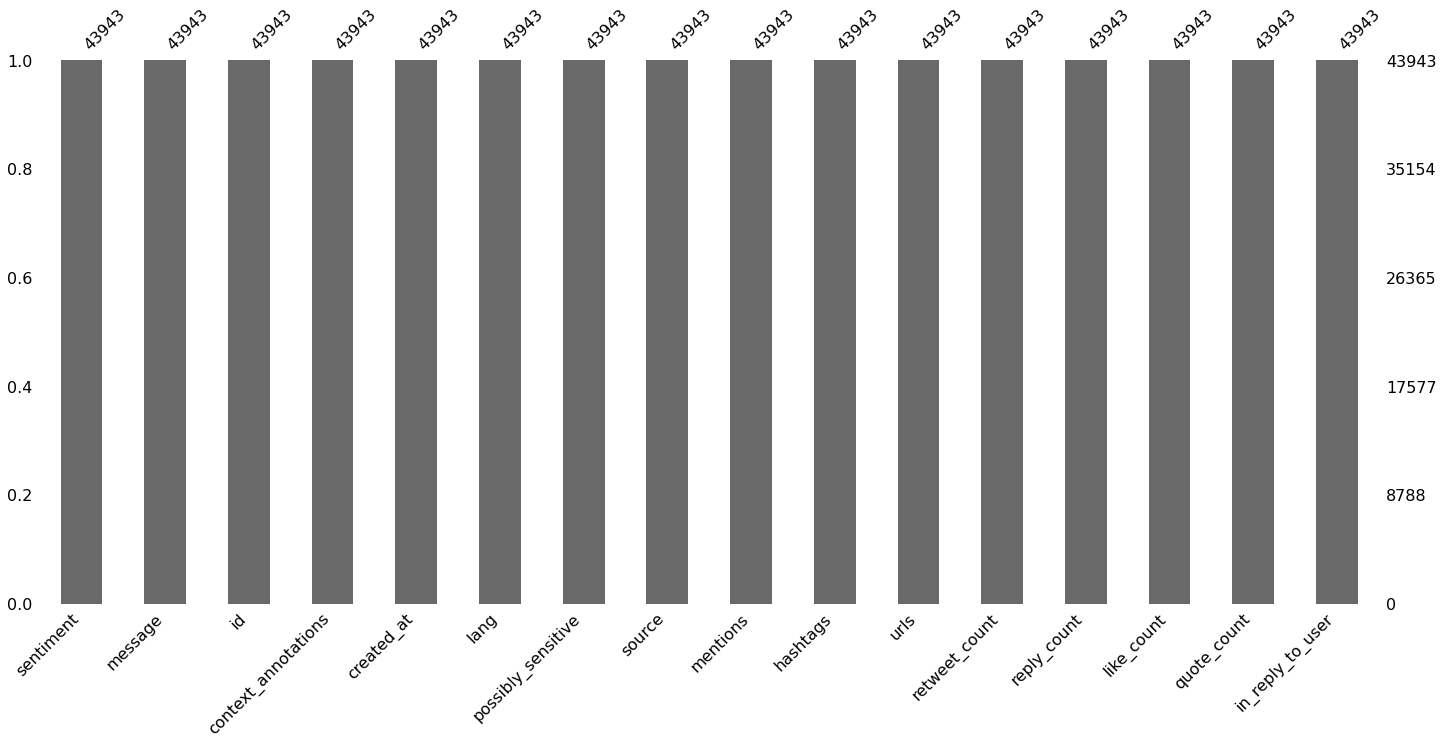

In [22]:
# missing value percentage
labelled_clean = labelled_with_meta.copy()
msno.bar(labelled_clean)

## Unlabelled Data

This unlabelled dataset was scraped with `twarc` according to following keywords:
* #climatechange
* #energy
* #renewables
* #renewableenergy
* #solar
* #climate
* #water
* #cleanenergy
* #climateaction
* #solarenergy
* #windpower
* #environment
* #eco
* climate
* climate change
* environment


Source: Twitter API

Size of Dataset: 99940 x 159

In [23]:
from twarc.expansions import flatten

def transform_data_(path_):
    """
    Reads a folder and transforms all json and jsonl files output by Twarc 
    into a single dataframe

    param: path_ Path to folder containing json/jsonl files
    returns: A pandas dataframe representation of the tweets and metadata
    output by Twarc
    """
    def flatten_json(json_object):
        with open(json_object, "r") as infile:
            data = [flatten(json.loads(line)) for line in infile]
        
        return data

    def dict_to_cols(df, col, prefix=""):
        tmp = pd.json_normalize(df[col]).add_prefix(prefix)
        df.drop(columns=[col], inplace=True)
        return pd.concat([df, tmp], axis=1).reset_index(drop=True)
    
    nested_cols = [
                    {'col': 'attachments', 'prefix': 'attachment_'},
                    {'col': 'entities', 'prefix': 'entities_'},
                    {'col': 'public_metrics', 'prefix': 'public_metrics_'},
                    {'col': 'author', 'prefix': 'author_'},
                    {'col': '__twarc', 'prefix': '__twarc_'},
                    {'col': 'in_reply_to_user', 'prefix': 'in_reply_to_user_'},
                    {'col': 'referenced_tweets', 'prefix': 'referenced_tweets_'}
                    ]
    data = []
    # Make sure only json files are read
    extensions = ["*.json", "*.jsonl"]
    print('Dowload file into json objects list...')
    for ext in extensions:
        files = Path(path_).glob(ext)
        for file in files:
            print(file)
            data += flatten_json(file)
    
    print('DataFrame construction...')
    df = pd.concat(list(map(pd.DataFrame.from_dict, data))).reset_index(drop=True)
    
    print('Unnested cols...')
    df['referenced_tweets'] = df['referenced_tweets'].apply(lambda x: x[0] if isinstance(x, list) else x)
    df.drop(columns=['context_annotations'], inplace=True)
    for col in nested_cols:
        df = dict_to_cols(df, col['col'], col['prefix'])
    return df

In [24]:
unlabelled = transform_data_(os.path.join(PROJECT_DIR, 'data/unlabeled'))
unlabelled.shape

Dowload file into json objects list...
/Users/mahora65/Desktop/ML-group/data/unlabeled/green.json
/Users/mahora65/Desktop/ML-group/data/unlabeled/tweets_terje.json
/Users/mahora65/Desktop/ML-group/data/unlabeled/sustainable.json
/Users/mahora65/Desktop/ML-group/data/unlabeled/climate.json
/Users/mahora65/Desktop/ML-group/data/unlabeled/stream.jsonl
/Users/mahora65/Desktop/ML-group/data/unlabeled/steam2.jsonl
/Users/mahora65/Desktop/ML-group/data/unlabeled/stream1.jsonl
DataFrame construction...
Unnested cols...


(99940, 159)

When we scrape tweets from the Twitter API we will get tweets from multiple languages. However, since most NLP packages mostly only work on **English**. We will drop all other languages.

In [25]:
# top 10 language in unlabelled dataset
unlabelled['lang'].value_counts().nlargest(10)

en     92367
und     3628
it      1082
ja       429
es       407
fr       299
de       192
ko       159
pt       128
in       126
Name: lang, dtype: int64

In [26]:
unlabelled = unlabelled[unlabelled['lang'] == 'en']
unlabelled.shape

(92367, 159)

Like what we do in labelled dataset, there are some columns which we want to transform it into a binary data.

In [27]:
def transform_references_binary(df, col_prefix, id_col=None):
    cols = [col for col in df.columns if col_prefix in col]
    if not id_col:
        id_col = f"{col_prefix}_id"
    # print(id_col, cols)
    binar_col = (df.copy()
        .loc[:, id_col]
        .fillna(0)
        .apply(lambda x: np.where(x == 0, 0, 1))
        .rename(col_prefix)
        )
    
    transformed_df = (pd.concat([df, binar_col], axis=1)
                    .drop(cols, axis=1)
                    )

    return  transformed_df

unlabelled= (unlabelled.loc[:,~unlabelled.columns.duplicated()]
                     .pipe(transform_references_binary, "referenced_tweets")
                     .pipe(transform_references_binary, "in_reply_to_user")
                     .pipe(transform_references_binary, "attachment_poll", "attachment_poll.id")
                     .pipe(transform_references_binary, "attachment_media", "attachment_media")
                     )

Now we check for the missing value.

<AxesSubplot:>

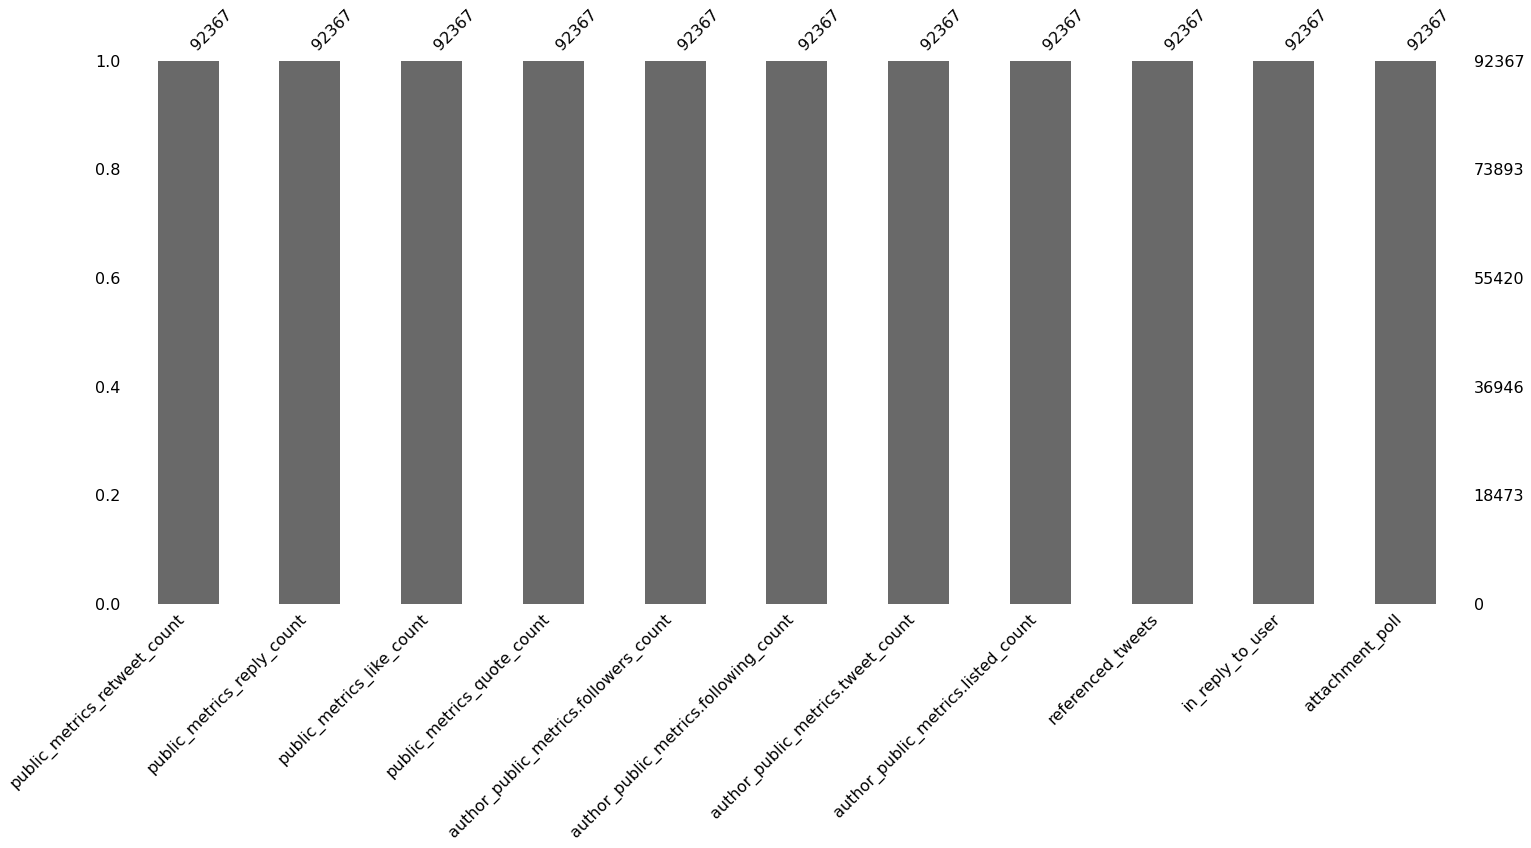

In [28]:
# check numerical cols null
msno.bar(unlabelled.select_dtypes(include= 'number'))

<AxesSubplot:>

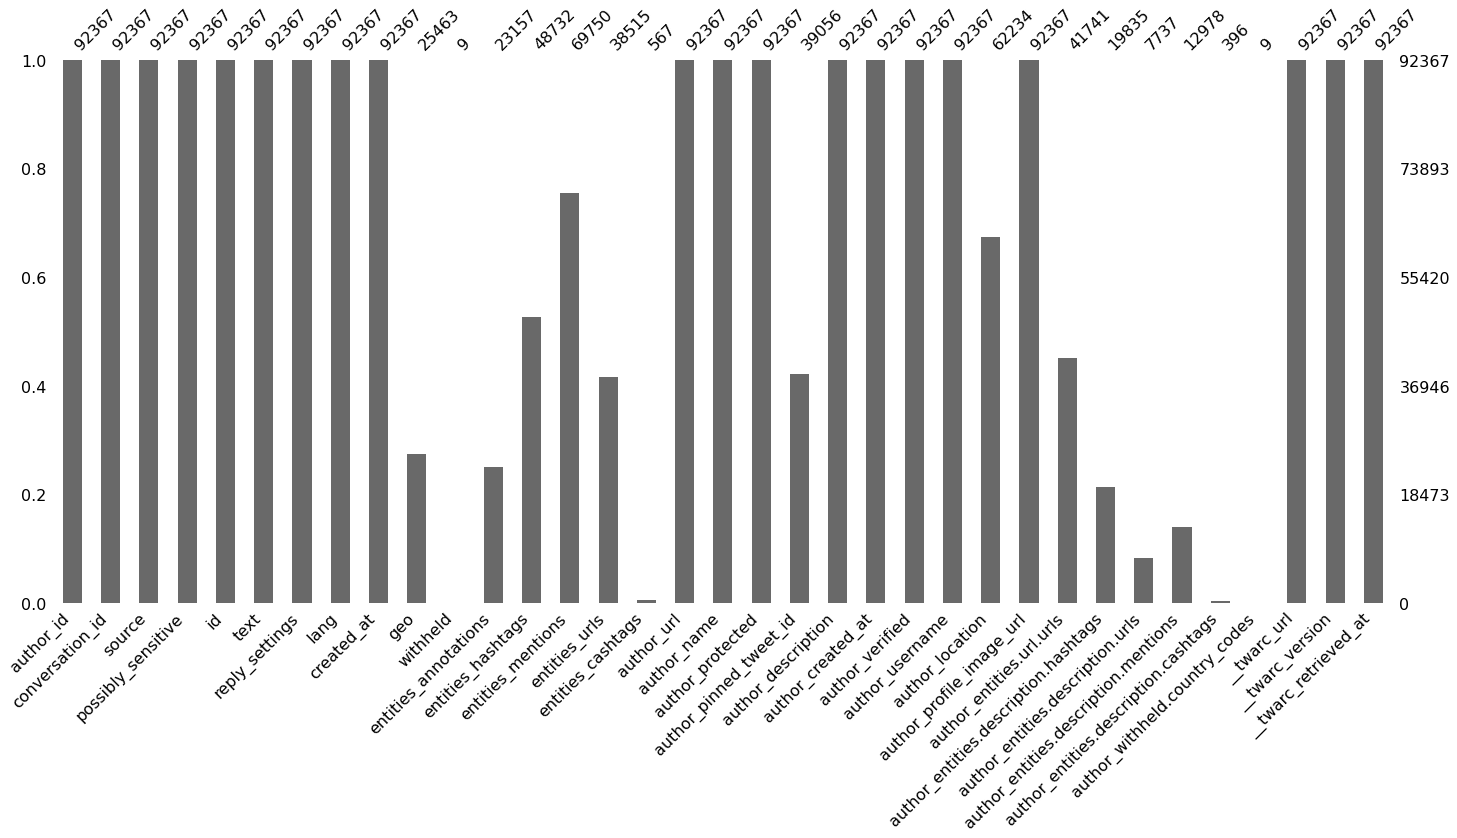

In [29]:
# check non-numerical cols null
msno.bar(unlabelled.select_dtypes(include= ['bool', 'object']))

First, we investigating `geo` cols.

<AxesSubplot:>

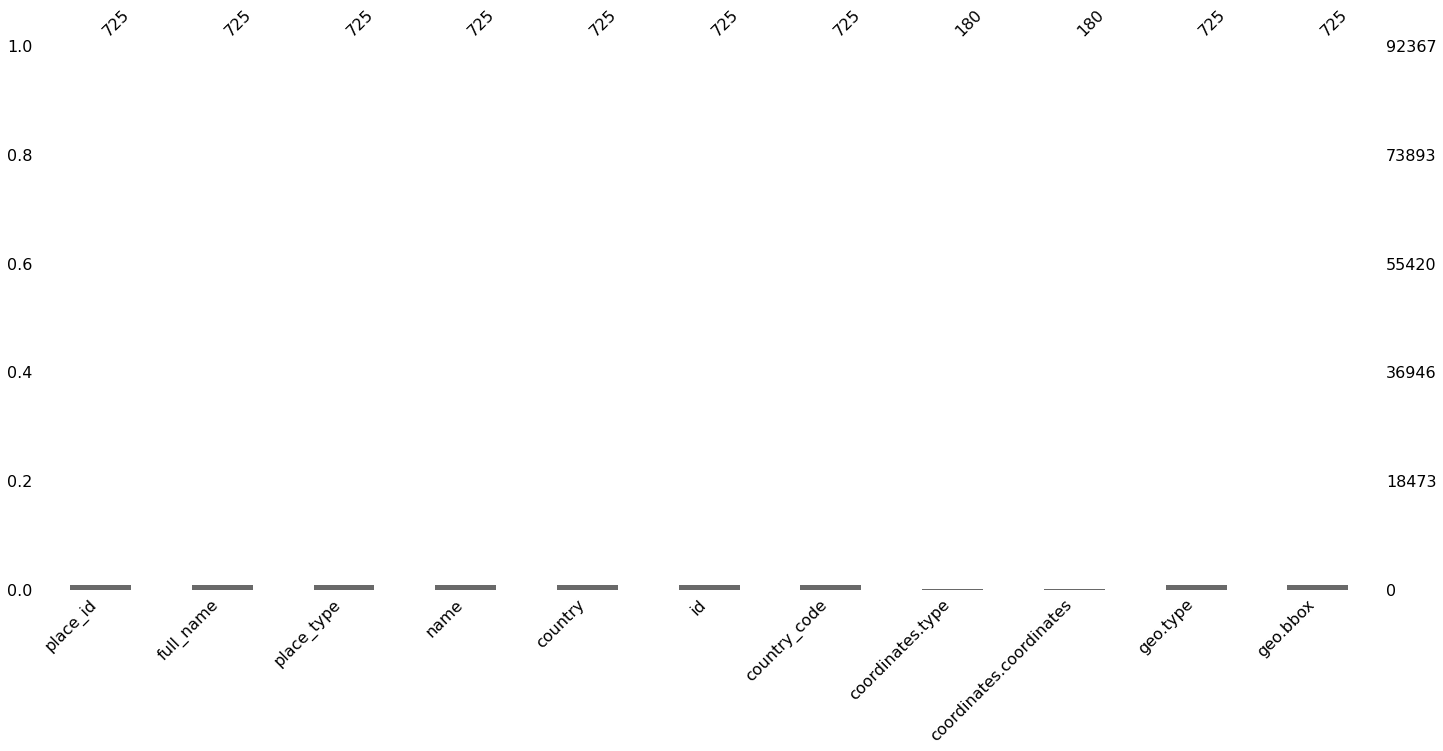

In [30]:
msno.bar(pd.json_normalize(unlabelled.geo))

We can see the there are only 725 non-missing values out of 92367 observations. There are too many missing value and this columns barely contains information at all. Therefore, we will drop it.

Next, we look at `author_entities`

<AxesSubplot:>

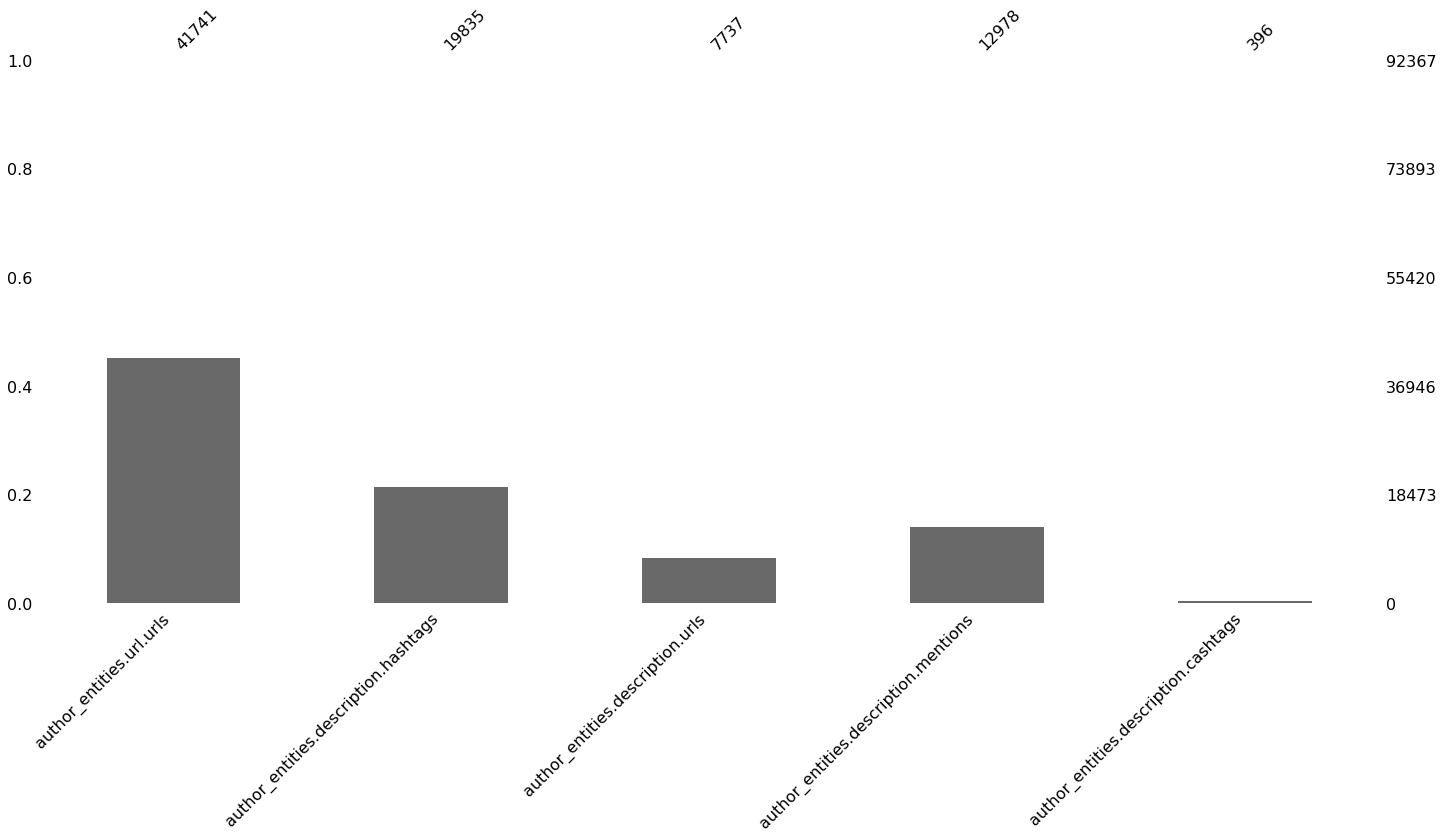

In [31]:
msno.bar(unlabelled[[col for col in unlabelled.columns if 'author_entities' in col]])

The columns from `author_entities` is also barely contains any information at all. We will also drop them along with all the columns which has too many missing value.

In [32]:
cols = ['geo', 'author_withheld.country_codes', 'withheld', 'entities_cashtags', 'entities_annotations', 'author_pinned_tweet_id'] + [col for col in unlabelled.columns if 'author_entities' in col]
unlabelled.drop(cols, axis=1, inplace=True)
unlabelled.shape

(92367, 35)

In [33]:
unlabelled.head(3)

author_id      conversation_id               source  \
0           4876038363  1493875450086666242  Twitter for Android   
1  1260116106624172038  1493875341068496900      Twitter Web App   
2           3092759386  1493875303571197952       Hootsuite Inc.   

   possibly_sensitive                   id  \
0               False  1493875450086666242   
1               False  1493875341068496900   
2               False  1493875303571197952   

                                                text reply_settings lang  \
0  RT @3Dprint_Seattle: A HDR taken at Fort Flagl...       everyone   en   
1  Oh hey there—wanna chat about why green is act...       everyone   en   
2  The Mayor of London, Sadiq Khan, today outline...       everyone   en   

                 created_at  \
0  2022-02-16T09:10:36.000Z   
1  2022-02-16T09:10:10.000Z   
2  2022-02-16T09:10:01.000Z   

                                   entities_hashtags  ...  \
0  [{'start': 72, 'end': 76, 'tag': 'HDR'}, {'sta...  ...   
1  [{'start': 94, 'end': 101, 'tag': 'matcha'}, {...  ...   
2  [{'start': 153, 'end': 160, 'tag': 'London'}, ...  ...   

  author_public_metrics.followers_count author_public_metrics.following_count  \
0                                  1549                                   334   
1                                   754                                     0   
2                                  9543                                  6554   

   author_public_metrics.tweet_count  author_public_metrics.listed_count  \
0                             546771                                  26   
1                                360                                   0   
2                              21119                                   0   

                                         __twarc_url  __twarc_version  \
0  https://api.twitter.com/2/tweets/search/recent...            2.9.2   
1  https://api.twitter.com/2/tweets/search/recent...            2.9.2   
2  https://api.twitter.com/2/tweets/search/recent...            2.9.2   

        __twarc_retrieved_at referenced_tweets  in_reply_to_user  \
0  2022-02-16T09:11:06+00:00                 1                 0   
1  2022-02-16T09:11:06+00:00                 0                 0   
2  2022-02-16T09:11:06+00:00                 0                 0   

  attachment_poll  
0               0  
1               0  
2               0  

[3 rows x 35 columns]

We still need to decode `entities_hashtags`, `entities_mentions`, and `entities_urls`.

In [34]:
for key, var in {'entities_hashtags': 'tag', 'entities_mentions': 'username', 'entities_urls': 'expanded_url'}.items():
    unlabelled[key] = unlabelled[key].apply(lambda y: [x[var] for x in y] if isinstance(y, list) else [])

<AxesSubplot:>

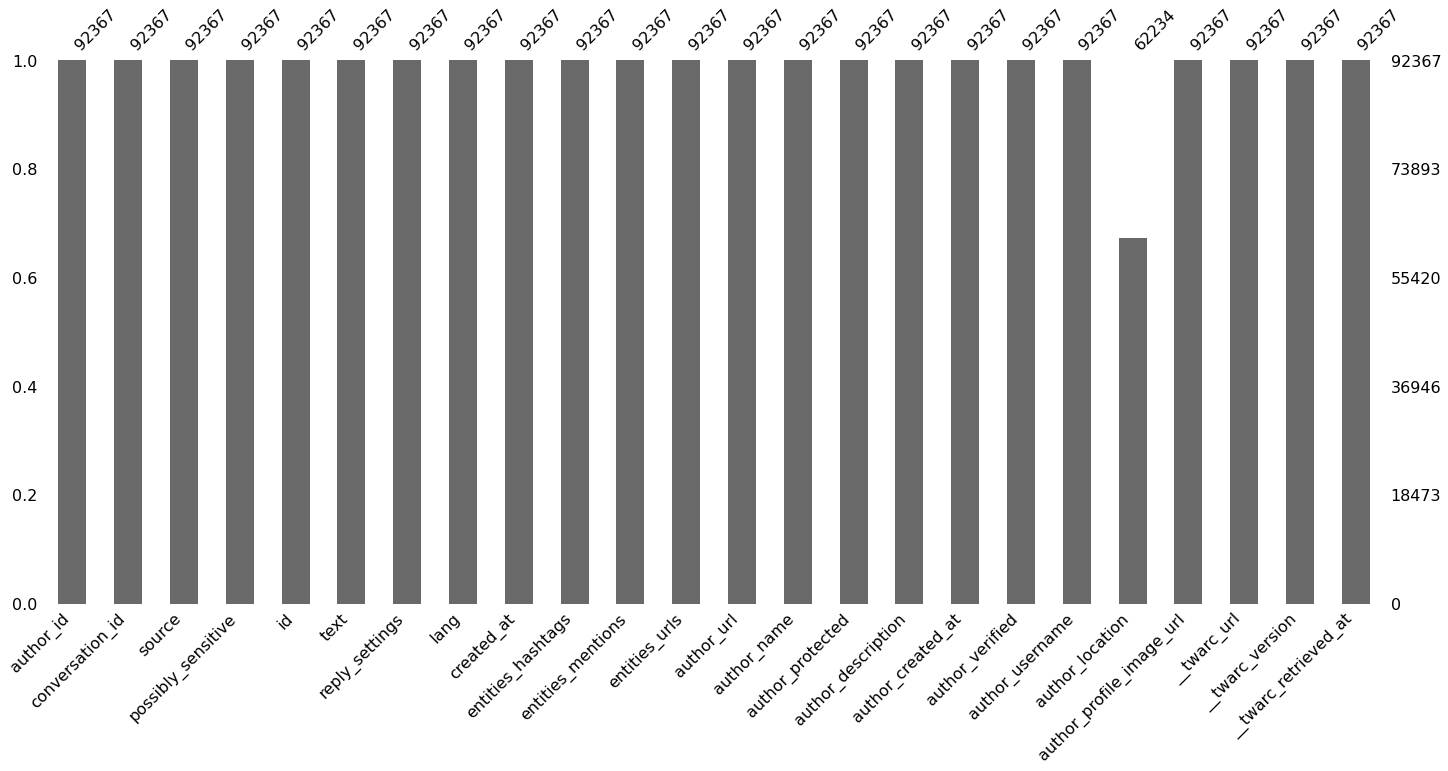

In [35]:
# check non-numerical cols null
msno.bar(unlabelled.select_dtypes(include= ['bool', 'object']))

## Dealing with author locations

The author location column represents a free text field where the tweet author can put any free form text. As such, it has a wide variety of text data, with some being locations and some not. Furthermore, some of the locations might contain spelling errors, and can be a mix of city, country, region etc.

It could still be useful to include the column in our model, so we will try to process the column using the geograpy3 package. Geograpy3 uses NLTK entity matching to find locations in text. It could allow us to extract country names from the relativelty messy author_location column.

In [36]:
# import geograpy
# import nltk
# nltk.download(["names",
#                "stopwords",
#                "punkt",
#                "vader_lexicon",
#                'maxent_ne_chunker',
#                'words'])
#
#
# unique_locations = pd.DataFrame([[k,v.values]
#                         for k,v in unlabelled.groupby('author_location').groups.items()],
#                       columns=['author_location','indices'])
#
# unique_locations["author_location"].fillna("none").apply(lambda x: geograpy.get_place_context(text=x).countries)
#
# unlabelled["author_location"] = (unlabelled["author_location"].fillna("none")
#                                         .apply(lambda x: geograpy.get_place_context(text=x).countries))

In [37]:
unlabelled_cleaned = unlabelled.copy()

Now we merging the data

In [38]:
# Merging the data
rename_cols = {"text": "message", "entities_hashtags": "hashtags", 
               "entities_mentions": "mentions", "entities_urls": "urls"}

unlabelled_cleaned.columns = unlabelled_cleaned.columns.str.replace("public_metrics_", "")
unlabelled_cleaned.columns = unlabelled_cleaned.columns.str.replace("entities_", "")
unlabelled_cleaned = unlabelled_cleaned.rename(columns=rename_cols)

joined = labelled_clean.append(unlabelled_cleaned).reset_index(drop= True)
joined.shape

/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_1816/1817362512.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joined = labelled_clean.append(unlabelled_cleaned).reset_index(drop= True)


(136310, 37)

<AxesSubplot:>

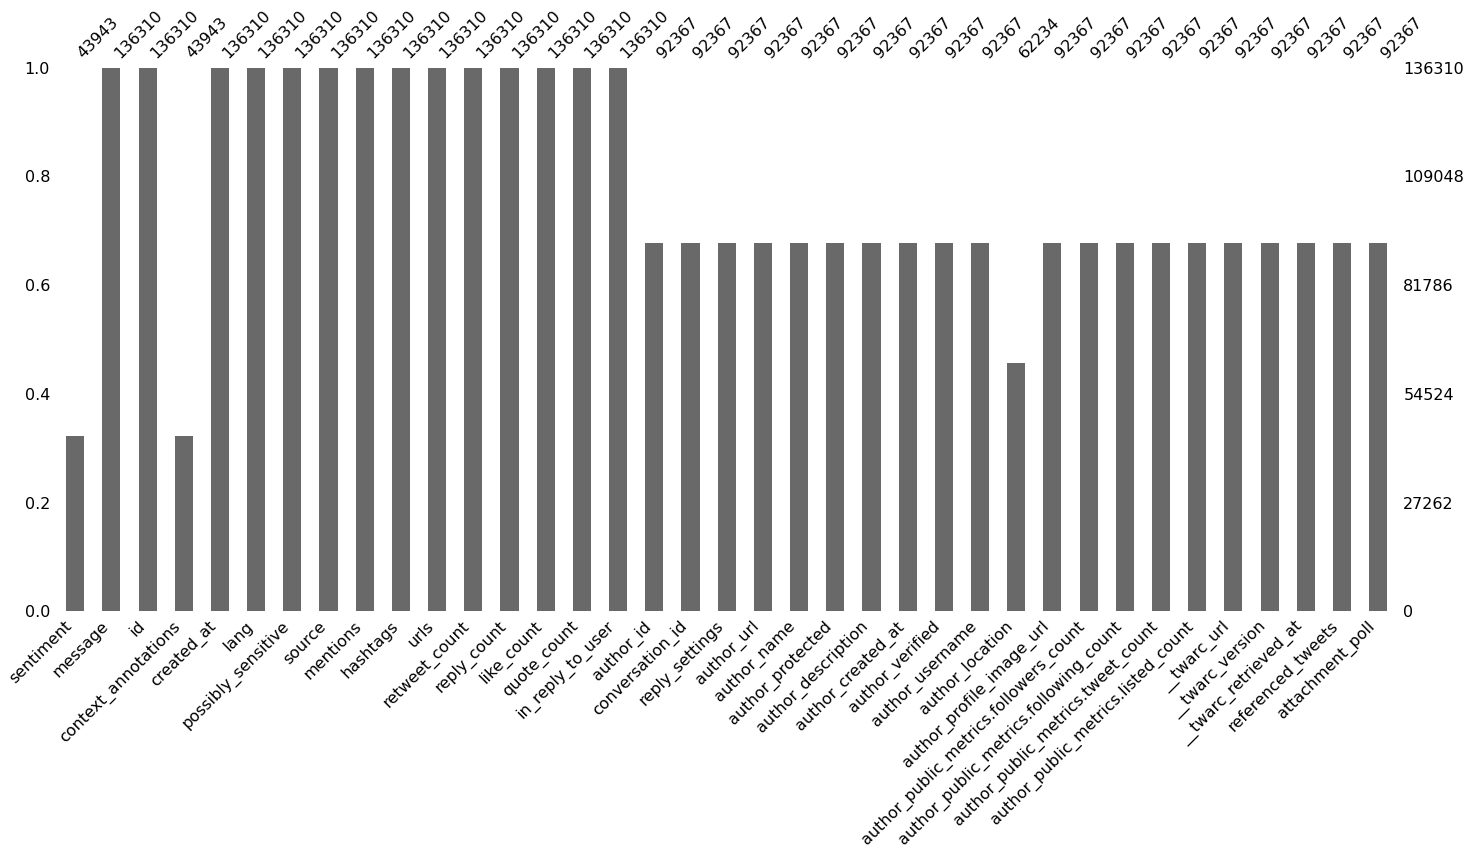

In [39]:
msno.bar(joined)

again, we will fill all the missing value with `mode` of each columns.

In [40]:
dict_fill = {'sentiment': -5,
             'author_public_metrics.followers_count': 546,
             'author_public_metrics.following_count': 547,
             'author_public_metrics.tweet_count': 8.675e+03,
             'author_public_metrics.listed_count': 4,
             'referenced_tweets': 1,
             'attachment_poll': 0
             }

for col, var in dict_fill.items():
    joined[col] = joined[col].fillna(var) 

In [41]:
joined.head(5)

sentiment                                            message  \
0       -1.0  @tiniebeany climate change is an interesting h...   
1        1.0  RT @NatGeoChannel: Watch #BeforeTheFlood right...   
2        1.0  Fabulous! Leonardo #DiCaprio's film on #climat...   
3        1.0  RT @Mick_Fanning: Just watched this amazing do...   
4        2.0  RT @cnalive: Pranita Biswasi, a Lutheran from ...   

                     id                                context_annotations  \
0  792927353886371840.0  [Extreme Weather + Climate Change, Discovery V...   
1  793124211518832640.0                                                 []   
2  793124402388832256.0                                                 []   
3  793124635873275904.0  [Extreme Weather + Climate Change, Discovery V...   
4  793125156185137152.0  [Extreme Weather + Climate Change, Discovery V...   

                  created_at lang  possibly_sensitive               source  \
0  2016-10-31 03:13:07+00:00   en               False  Twitter for Android   
1  2016-11-16 19:10:03+00:00   en               False   Twitter for iPhone   
2  2016-10-31 16:16:07+00:00   en               False   Twitter Web Client   
3  2016-10-31 16:17:03+00:00   en               False   Twitter Web Client   
4  2016-10-31 16:19:07+00:00   en               False  Twitter for Android   

         mentions             hashtags  ... author_profile_image_url  \
0    [tiniebeany]                   []  ...                      NaN   
1              []                   []  ...                      NaN   
2       [YouTube]  [DiCaprio, climate]  ...                      NaN   
3  [Mick_Fanning]                   []  ...                      NaN   
4       [cnalive]                   []  ...                      NaN   

   author_public_metrics.followers_count  \
0                                  546.0   
1                                  546.0   
2                                  546.0   
3                                  546.0   
4                                  546.0   

   author_public_metrics.following_count  author_public_metrics.tweet_count  \
0                                  547.0                             8675.0   
1                                  547.0                             8675.0   
2                                  547.0                             8675.0   
3                                  547.0                             8675.0   
4                                  547.0                             8675.0   

   author_public_metrics.listed_count  __twarc_url __twarc_version  \
0                                 4.0          NaN             NaN   
1                                 4.0          NaN             NaN   
2                                 4.0          NaN             NaN   
3                                 4.0          NaN             NaN   
4                                 4.0          NaN             NaN   

  __twarc_retrieved_at referenced_tweets attachment_poll  
0                  NaN               1.0             0.0  
1                  NaN               1.0             0.0  
2                  NaN               1.0             0.0  
3                  NaN               1.0             0.0  
4                  NaN               1.0             0.0  

[5 rows x 37 columns]

# Clustering

ours aim is to assign a label to unlabelled dataset by clustering it with labelled dataset.

## Labelled data

First, we need to get numerical values and split the labels.

In [42]:
num_labelled = labelled_clean.select_dtypes(include= 'number')
y = num_labelled['sentiment']
num_labelled = num_labelled.drop(['id', 'sentiment'], axis=1)

We have 7 numerical attribute in total. if we need to plot his it will be 7 dimensional plot which is beyond humans perceptions. We gonna use PCA to reduces it to 2D.

<AxesSubplot:xlabel='x', ylabel='y'>

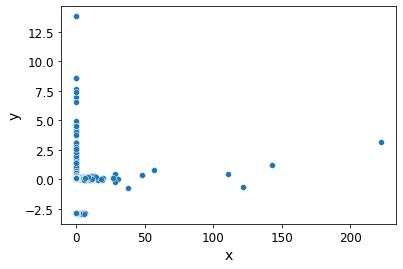

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
pca_2 = PCA(n_components= 2)
std_labelled = std_scaler.fit_transform(num_labelled)
X2D = pca_2.fit_transform(std_labelled)
labelled_X2D = pd.DataFrame(X2D, columns= ['x','y'])

sns.scatterplot(x= 'x', y= 'y', data= labelled_X2D)

Then, we try cluster the dataset with `KMeans` with 4 cluster, which is equal to 4 classes of labels.

In [44]:
from sklearn.cluster import KMeans

km_cluster = KMeans(
    n_clusters=4, init= 'random',
    n_init = 20, max_iter= 10_000,
    tol= 1e-04, random_state=0
)


y_km = km_cluster.fit_predict(labelled_X2D)

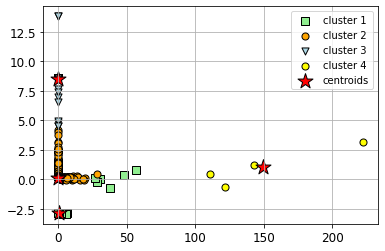

In [45]:
plt.scatter(
    labelled_X2D[y_km==0]['x'], labelled_X2D[y_km==0]['y'],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    labelled_X2D[y_km == 1]['x'], labelled_X2D[y_km == 1]['y'],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    labelled_X2D[y_km == 2]['x'], labelled_X2D[y_km == 2]['y'],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    labelled_X2D[y_km == 3]['x'], labelled_X2D[y_km == 3]['y'],
    s=50, c='yellow',
    marker='o', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    km_cluster.cluster_centers_[:, 0], km_cluster.cluster_centers_[:, 1],
    s=250, marker="*",
    c='red', edgecolor='black',
    label= 'centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

Now we plot the distribution of the class and cluster with heatmap.

<AxesSubplot:xlabel='sentiment', ylabel='row_0'>

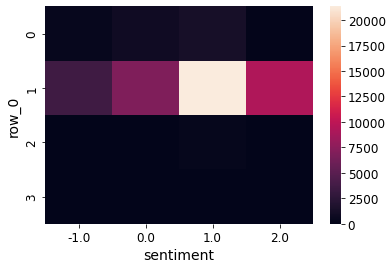

In [46]:
sns.heatmap(pd.crosstab(y_km, y))

## Unlabelled data

In [47]:
num_unlabelled = unlabelled_cleaned.select_dtypes(include= 'number')
num_unlabelled.shape

(92367, 11)

We have 11 numberical attribute in total. If we need to plot this it will be 11 

<AxesSubplot:xlabel='x', ylabel='y'>

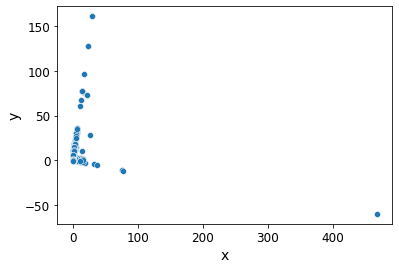

In [48]:
std_df = std_scaler.fit_transform(num_unlabelled)
X2D = pca_2.fit_transform(std_df)
unlabelled_X2D = pd.DataFrame(X2D, columns=['x', 'y'])


sns.scatterplot(x= 'x', y= 'y', data= unlabelled_X2D)

Now we have to check outliners, we have 2 on the `x` axis and 3 on the `y` axis

In [49]:
# outliner on x axis
unlabelled.iloc[unlabelled_X2D.nlargest(2, 'x').index]

author_id      conversation_id                source  \
31742            124003770  1493839647696326659      Tweetbot for iΟS   
72700  1484309498458443776  1492467184496349184  Twitter Media Studio   

       possibly_sensitive                   id  \
31742               False  1493851972755021824   
72700               False  1492467184496349184   

                                                    text reply_settings lang  \
31742  @guinghyung BRAVO‼️LET WOMEN DO IT‼️LET LENI,&...       everyone   en   
72700  We fixed it #auspol #climate https://t.co/WeLk...       everyone   en   

                     created_at   entities_hashtags  ...  \
31742  2022-02-16T07:37:19.000Z  [2GETHERWERSTRONG]  ...   
72700  2022-02-12T11:54:40.000Z   [auspol, climate]  ...   

      author_public_metrics.followers_count  \
31742                               3976198   
72700                                  1316   

      author_public_metrics.following_count  \
31742                                   192   
72700                                  1404   

       author_public_metrics.tweet_count  author_public_metrics.listed_count  \
31742                              35366                               11739   
72700                                107                                   4   

                                             __twarc_url  __twarc_version  \
31742  https://api.twitter.com/2/tweets/search/recent...            2.9.2   
72700  https://api.twitter.com/2/tweets/search/recent...            2.9.2   

            __twarc_retrieved_at referenced_tweets  in_reply_to_user  \
31742  2022-02-16T08:41:26+00:00                 1                 1   
72700  2022-02-16T08:51:36+00:00                 0                 0   

      attachment_poll  
31742               0  
72700               0  

[2 rows x 35 columns]

In [50]:
# outliner on y axis
unlabelled.iloc[unlabelled_X2D.nlargest(3, 'y').index]

author_id      conversation_id      source  possibly_sensitive  \
90649   5988062  1493999013351370756  SocialFlow               False   
78795   2467791  1493975237267968007  SocialFlow               False   
88209  14293310  1493994332810059778    Sprinklr               False   

                        id                                               text  \
90649  1493999013351370756  “Xi Jinping indulges Vladimir Putin because Ru...   
78795  1493975237267968007  Student climate activists from Yale, Stanford,...   
88209  1493994332810059778  The megadrought deepened so much last year tha...   

      reply_settings lang                created_at entities_hashtags  ...  \
90649       everyone   en  2022-02-16T17:21:36.000Z                []  ...   
78795       everyone   en  2022-02-16T15:47:07.000Z                []  ...   
88209       everyone   en  2022-02-16T17:03:00.000Z                []  ...   

      author_public_metrics.followers_count  \
90649                              26235642   
78795                              18696312   
88209                              18591021   

      author_public_metrics.following_count  \
90649                                   136   
78795                                  1715   
88209                                   509   

       author_public_metrics.tweet_count  author_public_metrics.listed_count  \
90649                             294455                              119539   
78795                             419195                              104913   
88209                             387376                              104922   

                                             __twarc_url  __twarc_version  \
90649  https://api.twitter.com/2/tweets/search/stream...            2.9.2   
78795  https://api.twitter.com/2/tweets/search/stream...            2.9.2   
88209  https://api.twitter.com/2/tweets/search/stream...            2.9.2   

            __twarc_retrieved_at referenced_tweets  in_reply_to_user  \
90649  2022-02-16T17:21:47+00:00                 0                 0   
78795  2022-02-16T15:47:18+00:00                 0                 0   
88209  2022-02-16T17:03:11+00:00                 0                 0   

      attachment_poll  
90649               0  
78795               0  
88209               0  

[3 rows x 35 columns]

**Observation**
* The outliner on `x` axis are tweets which is popular itself.
* The outliner on `y` axis are tweets that come from popular authors

[]

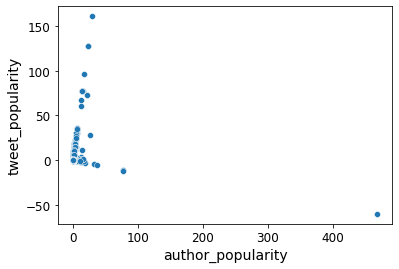

In [51]:
sns.scatterplot(x= 'x', y= 'y', data= unlabelled_X2D)
plt.xlabel('author_popularity')
plt.ylabel('tweet_popularity')
plt.plot()

We will try remove the outliner to zoom into the cluster

[]

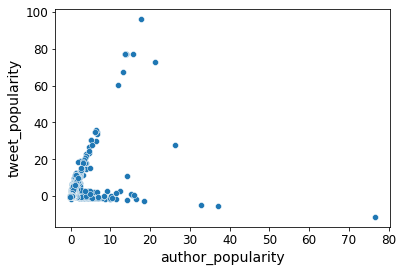

In [52]:
# remove outliner
outliner_rows = list(unlabelled_X2D.nlargest(2, 'x').index) + list(unlabelled_X2D.nlargest(3, 'y').index)

unlabelled_X2D.drop(outliner_rows, inplace= True)
sns.scatterplot(x= 'x', y= 'y', data= unlabelled_X2D)
plt.xlabel('author_popularity')
plt.ylabel('tweet_popularity')
plt.plot()

In [53]:
from sklearn.cluster import KMeans

km_cluster = KMeans(
    n_clusters=4, init= 'random',
    n_init = 20, max_iter= 1_000,
    tol= 1e-04, random_state=0
)

y_km = km_cluster.fit_predict(unlabelled_X2D)

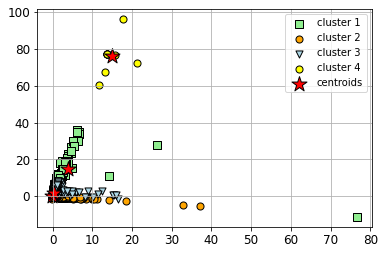

In [54]:
plt.scatter(
    unlabelled_X2D[y_km==0]['x'], unlabelled_X2D[y_km==0]['y'],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    unlabelled_X2D[y_km == 1]['x'], unlabelled_X2D[y_km == 1]['y'],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    unlabelled_X2D[y_km == 2]['x'], unlabelled_X2D[y_km == 2]['y'],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    unlabelled_X2D[y_km == 3]['x'], unlabelled_X2D[y_km == 3]['y'],
    s=50, c='yellow',
    marker='o', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    km_cluster.cluster_centers_[:, 0], km_cluster.cluster_centers_[:, 1],
    s=250, marker="*",
    c='red', edgecolor='black',
    label= 'centroids'
)

plt.legend(scatterpoints=1)
plt.grid()
plt.show()

## Semi-labelled

In [55]:
num_join = joined.select_dtypes(include= 'number')
y = num_join['sentiment']
num_join = num_join.drop('sentiment', 1)

/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_1816/2715682597.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  num_join = num_join.drop('sentiment', 1)


<AxesSubplot:xlabel='x', ylabel='y'>

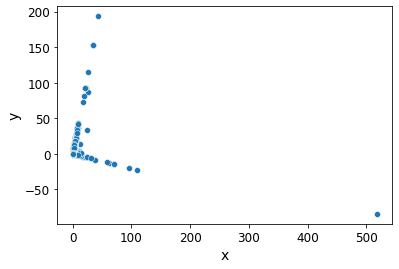

In [56]:
 from sklearn.decomposition import PCA
 from sklearn.preprocessing import StandardScaler

 std_scaler = StandardScaler()
 pca_2 = PCA(n_components= 2)
 std_join = std_scaler.fit_transform(num_join)
 X2D = pca_2.fit_transform(std_join)
 joined_X2D = pd.DataFrame(X2D, columns=['x', 'y'])
 joined_X2D['label'] = y


 sns.scatterplot(x= 'x', y= 'y', data= joined_X2D)

Now, we gonna drop 1 outliner on the `x` axis and 3 on the `y` axis. Then create a cluster.

In [57]:
joined_X2D.drop(list(joined_X2D.nlargest(1, 'x').index) + list(joined_X2D.nlargest(3, 'y').index), inplace= True)

In [58]:
from sklearn.cluster import KMeans

km_cluster = KMeans(
    n_clusters=4, init= 'random',
    n_init = 20, max_iter= 1_000,
    tol= 1e-04, random_state=0
)

y_km = km_cluster.fit_predict(joined_X2D[['x','y']])

And we plot distribution of the cluster and labels with heatmap.

<AxesSubplot:xlabel='label', ylabel='cluster'>

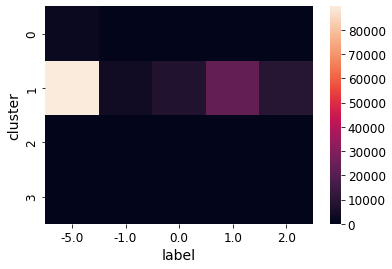

In [59]:
y_semi = pd.DataFrame(list(zip(y_km, joined_X2D['label'])), columns=['cluster', 'label'])

sns.heatmap(pd.crosstab(y_semi['cluster'], y_semi['label']))

In summary we couldn't assign the unlabelled data scraped from twitter api wiht the current labeled data. This might because of the time gaps between two database (labelled-2018, unlabelled-2022).

# EDA
It time to dissect the data, torturing it until it confess everything to us...

![](https://acuate.typepad.com/.a/6a0120a5e84a91970c0223c8514578200c-500wi)


## Preprocessing

In [60]:
df = labelled_clean.copy()

In [61]:
label_dict = {
    2 : 'News',
    1 : 'Pro',
    0 : 'Neutral',
    -1: 'Anti'
}

labels = df.sentiment.copy()
for key, var in label_dict.items():
    labels.loc[labels == key] = var

df['sentiment'] = labels

In [62]:
# Source: https://www.kaggle.com/nicolemeinie/sentiment-analysis-twitter-on-climate-change#Building-classification-models
def TweetCleaner(tweet):
    
    """
    This function uses regular expressions to remove url's, mentions, hashtags, 
    punctuation, numbers and any extra white space from tweets after converting 
    everything to lowercase letters.

    Input:
    tweet: original tweet
           datatype: 'str'

    Output:
    tweet: modified tweet
           datatype: 'str'
    """
    # Convert everything to lowercase
    tweet = tweet.lower() 
    
    # Remove mentions   
    tweet = re.sub('@[\w]*','',tweet)  
    
    # Remove url's
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)    
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)  
    
    # Remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    # Remove that funny diamond
    tweet = re.sub(r"U+FFFD ", ' ', tweet)
    
    # Remove extra whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove space in front of tweet
    tweet = tweet.lstrip(' ')                        
    
    return tweet

# Clean the tweets in the message column
df['message'] = df['message'].apply(TweetCleaner)

df.head(3)

<>:21: DeprecationWarning: invalid escape sequence '\w'
<>:21: DeprecationWarning: invalid escape sequence '\w'
/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_1816/3298420345.py:21: DeprecationWarning: invalid escape sequence '\w'
  tweet = re.sub('@[\w]*','',tweet)


sentiment                                            message            id  \
0      Anti  climate change is an interesting hustle as it ...  7.929274e+17   
1       Pro  rt watch right here as travels the world to ta...  7.931242e+17   
2       Pro  fabulous leonardo s film on change is brillian...  7.931244e+17   

                                 context_annotations  \
0  [Extreme Weather + Climate Change, Discovery V...   
1                                                 []   
2                                                 []   

                  created_at lang  possibly_sensitive               source  \
0  2016-10-31 03:13:07+00:00   en               False  Twitter for Android   
1  2016-11-16 19:10:03+00:00   en               False   Twitter for iPhone   
2  2016-10-31 16:16:07+00:00   en               False   Twitter Web Client   

       mentions             hashtags  \
0  [tiniebeany]                   []   
1            []                   []   
2     [YouTube]  [DiCaprio, climate]   

                                                urls  retweet_count  \
0                                                 []            0.0   
1                                                 []            0.0   
2  [http://www.youtube.com/watch?v=90CkXVF-Q8M&sn...            0.0   

   reply_count  like_count  quote_count  in_reply_to_user  
0          0.0         0.0          0.0                 1  
1          0.0         0.0          0.0                 0  
2          0.0         1.0          0.0                 0

In [63]:
color_dict = {
    'News': '#FCFC99',
    'Pro': '#79DE79',
    'Neutral': '#A8E4EF',
    'Anti': '#FB6962'
}

## Target Variable Distribution (`sentiment`)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


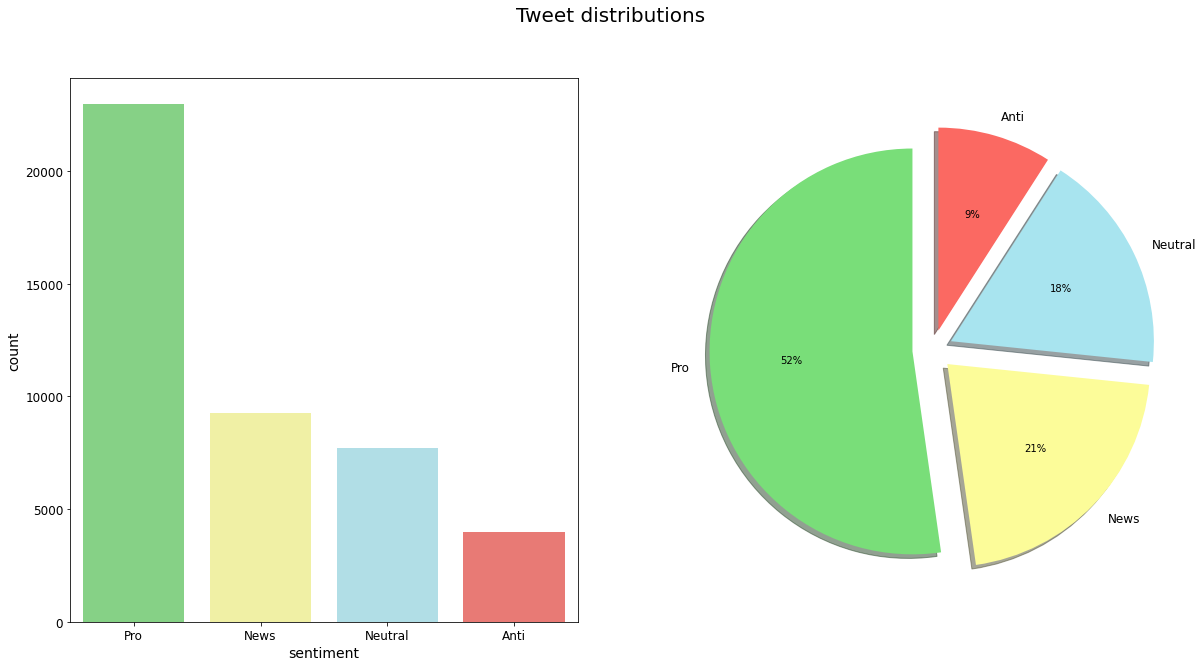

In [64]:
def plot_target_dist(df, order=None):
    fig, axes = plt.subplots(ncols= 2,
                             nrows= 1,
                             figsize= (20, 10))

    order = ['Pro', 'News', 'Neutral', 'Anti']

    sns.countplot(df, ax=axes[0],
                  order= order ,
                  palette= [color_dict[x] for x in order])

    axes[1].pie(df.value_counts(),
                labels= df.value_counts().index.to_list(),
                autopct= '%1.0f%%',
                shadow= True,
                startangle= 90,
                explode= (0.1, 0.1, 0.1, 0.1),
                colors= [color_dict[x] for x in order])
    fig.suptitle('Tweet distributions', fontsize=20)
    plt.show()

order = ['Pro', 'News', 'Neutral', 'Anti']
plot_target_dist(labels, order= order)

as we can see from graph our dataset is biased toward `Pro` tweets. This should effect greatly when we trying to create a model.

## Tweets Length

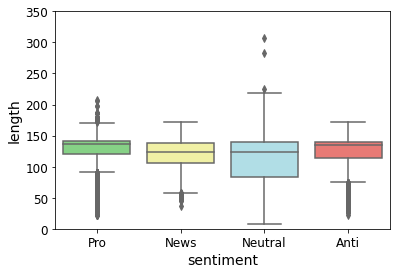

In [65]:
df['length'] = labelled_clean.message.str.len()

sns.boxplot(x=df['sentiment'], y=df['length'], data=df, order= order, palette= [color_dict[x] for x in order])
plt.ylim(0,350)
plt.show()

The `Neutral` tweets trends to be longer than others.

## Hashtags

In [66]:
import collections

dict= {'Pro': ['pro_hashtags', (0,0)],
       'News': ['news_hashtags', (0,1)],
       'Neutral': ['neutral_hashtags', (1,0)],
       'Anti': ['anti_hashtags', (1,1)]}


for key, var in dict.items():
    tmp = []
    for i in df[df.sentiment == key]['hashtags']:
        tmp += i
    globals()[var[0]] = pd.DataFrame(collections.Counter(tmp).most_common(15), columns=['hashtag', 'count'])

Now we will plot top 15 hashtags by `sentiment`.

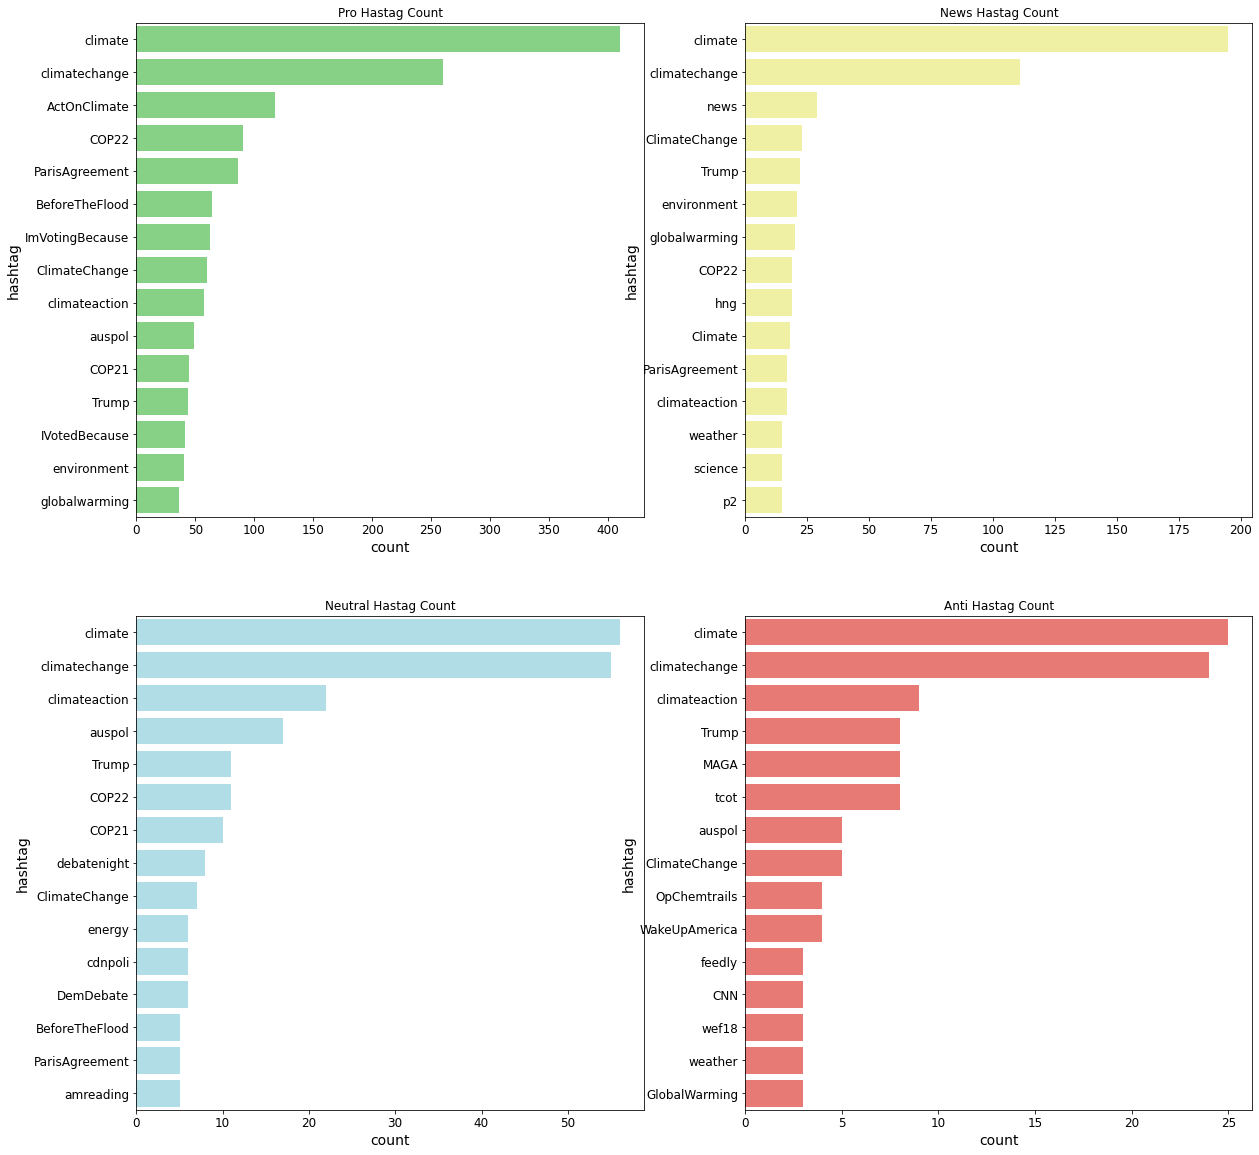

In [67]:
fig, axes = plt.subplots(ncols= 2,
                         nrows= 2,
                         figsize= (20, 20))

for key, var in dict.items():
    sns.barplot(y='hashtag', x='count', data= globals()[var[0]] , ax=axes[var[1]], color=color_dict[key])
    axes[var[1]].set_title(f'{key} Hastag Count')
plt.show()

## Mentions

In [68]:
dict= {'Pro': ['pro_mentions', (0,0)],
       'News': ['news_mentions', (0,1)],
       'Neutral': ['neutral_mentions', (1,0)],
       'Anti': ['anti_mentions', (1,1)]}


for key, var in dict.items():
    tmp = []
    for i in df[df.sentiment == key]['mentions']:
        tmp += i
    globals()[var[0]] = pd.DataFrame(collections.Counter(tmp).most_common(15), columns=['mention', 'count'])

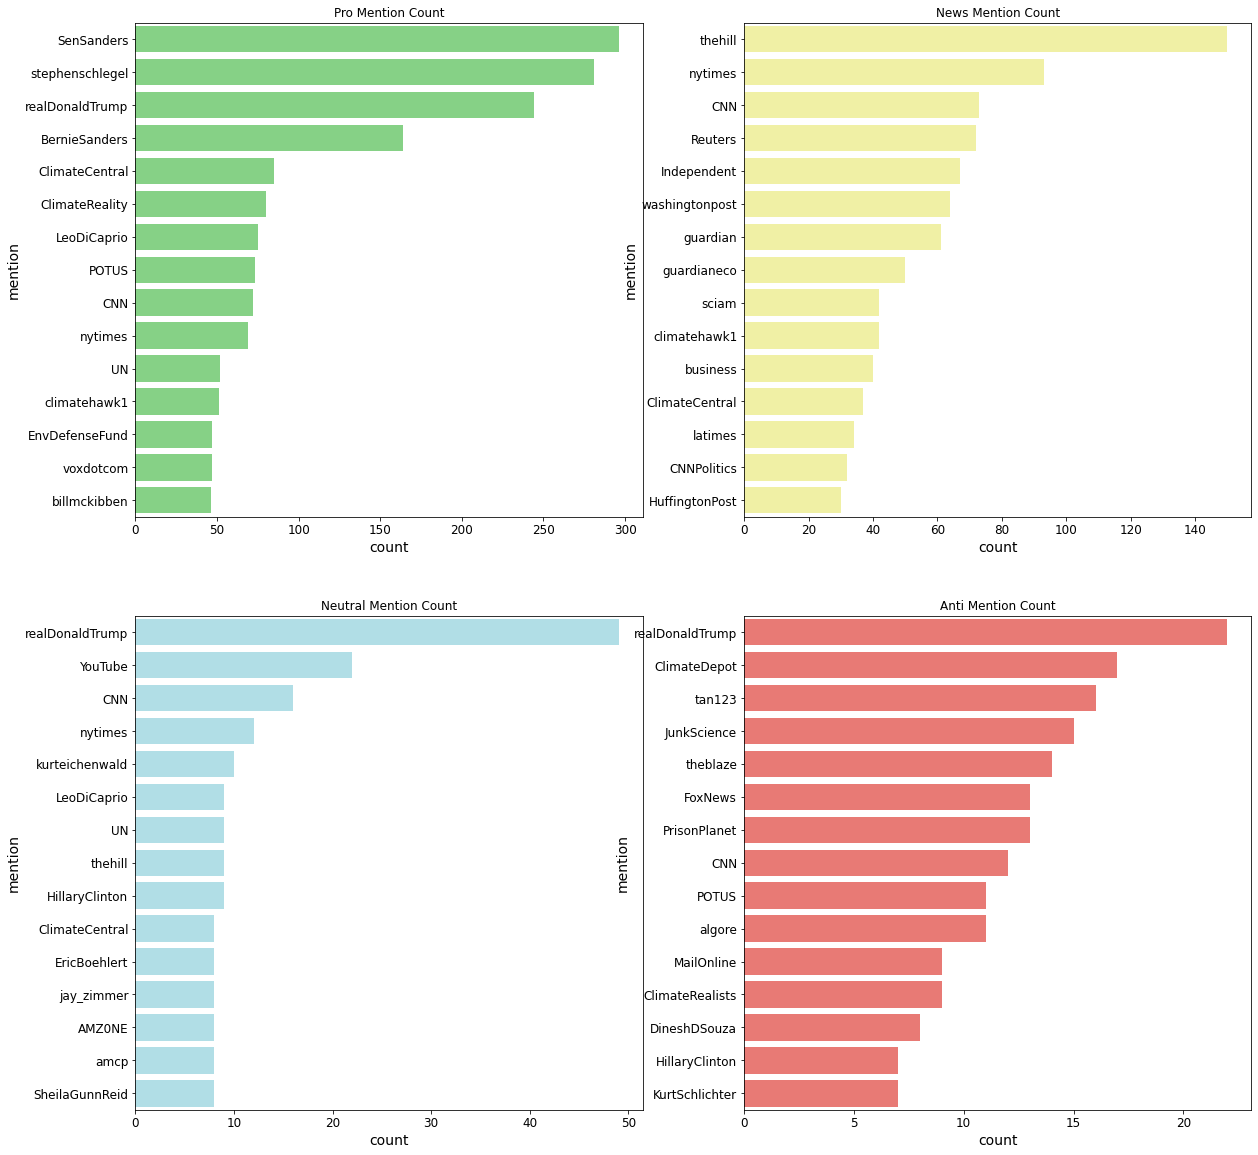

In [69]:
fig, axes = plt.subplots(ncols= 2,
                         nrows= 2,
                         figsize= (20, 20))

for key, var in dict.items():
    sns.barplot(y='mention', x='count', data= globals()[var[0]] , ax=axes[var[1]], color=color_dict[key])
    axes[var[1]].set_title(f'{key} Mention Count')

# Building the models
For our analysis we will focus on 3 models for classification due to hardware and time constraints.

- Random forest
- K nearest neighbor
- Linear SVC


## Splitting into training and test

Before we run our models we'll first split our data into a training and testing set. We'll be using a ratio of 8:2 for the training and test data respectively.

In [70]:
from sklearn.model_selection import train_test_split

# Use same numerical features as for previous clustering
labelled_clean["message"] = labelled_clean["message"].apply(TweetCleaner)
features = labelled_clean.select_dtypes(include=['number']).drop(["id", "sentiment"], axis=1).columns.to_list()
features.append('message')

X = labelled_clean[features]
y = labelled_clean['sentiment'].reset_index(drop=True)

# Splitting into trainng and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,  y_train.shape, X_test.shape, y_test.shape, features

((35154, 6),
 (35154,),
 (8789, 6),
 (8789,),
 ['retweet_count',
  'reply_count',
  'like_count',
  'quote_count',
  'in_reply_to_user',
  'message'])

## Setting up the pipelines
In order to more efficiently run our models we will set up 3 pipelines, one for each model. We will be using the TFIDF vectorized to transform our text into numbers, as machine learning models can only deal with numerical data. TFIDF uses word frequency scores to try to find words that are the most important in a given document. For the models we'll start with some preset hyperparameters, and then tune them using grid search later on.

In [71]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report


# https://stackoverflow.com/questions/67768470/valueerror-found-input-variables-with-inconsistent-numbers-of-samples-6-80
transformer = ColumnTransformer(
    [('vec', TfidfVectorizer(stop_words= 'english'), 'message')],   # column should be a string or int
    remainder='passthrough'
)

# Random Forest Classifier
rfc = Pipeline([('tfidf', transformer),
                ('scaler', StandardScaler(with_mean=False)),
               ('clf', RandomForestClassifier(max_depth=5,
                                              n_estimators=100,
                                              random_state=0))])

# K-NN Classifier
knn = Pipeline([('tfidf', transformer),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', KNeighborsClassifier(n_neighbors=5,
                                             metric='minkowski',
                                             p=2))])

# Linear SVC:
lsvc = Pipeline([('tfidf', transformer),
                 ('scaler', StandardScaler(with_mean=False)),
                 ('clf', LinearSVC(class_weight='balanced',
                                   random_state=0))])

### Functions for evaluating the models
In order to more easily evalute our models we'll create two functions that will take care of most of the work. One function displaying the accuracy, precision, recall and F1 score and one function to do the plotting.

For all models we will be using cross-validation to evaluate the models to avoid the testing data impacting our model building by using Sklearn's cross_val_predict function.

In [72]:
# Set up the function to show model scores
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_model(model, y_true, y_pred):
    print('Model: ', model)
    print(classification_report(y_true, y_pred))
    print('\n')


In [73]:
# Set up the function to plot the confusion matrix for all models
def plot_confusion_matrix(model, title, y_pred, y_true=y_train):
    cm = confusion_matrix(y_true, y_pred)
    norm_cm =  cm / cm.sum(axis=1).reshape(-1,1)
    sns.heatmap(norm_cm, annot=True, cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_,
                vmin=0, vmax=1)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Random forest model
Having set up our pipelines it's time for fitting and evaluting the models. We'll start by evaluating the random forest model.


In [74]:
# Fitting the random forest model
rfc.fit(X_train, y_train)
y_rfc_train_pred = cross_val_predict(rfc, X_train, y_train, cv=10, n_jobs= -1)

In [75]:
evaluate_model(rfc, y_train, y_rfc_train_pred)

Model:  Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', RandomForestClassifier(max_depth=5, random_state=0))])
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00      3206
         0.0       0.00      0.00      0.00      6133
         1.0       0.52      1.00      0.69     18448
         2.0       0.00      0.00      0.00      7367

    accuracy                           0.52     35154
   macro avg       0.13      0.25      0.17     35154
weighted avg       0.28      0.52      0.36     35154





/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

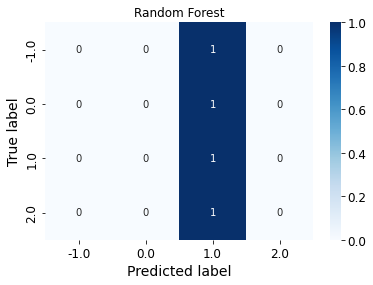

In [76]:
# Plotting the confusion matrix
plot_confusion_matrix(rfc, 'Random Forest', y_rfc_train_pred)

From the confusion matric and the precision, recall, and f1 score we can see that the random forest model is not performinc well. All tweets are predicted as being pro climate change, which is obviously not the case. We'll therefore move on with our other models.


### K-NN model

The K nearest neighbors model uses neighboring data-points to predict which class a new datapoint belongs to using a preset distance measure, like Euclidian distance. It uses majority voting and assigns the data point to the class with the most votes.


In [77]:
knn.fit(X_train, y_train)
y_knn_train_pred = cross_val_predict(knn, X_train, y_train, cv=10, n_jobs= -1)

In [78]:
evaluate_model(knn, y_train, y_knn_train_pred)

Model:  Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', KNeighborsClassifier())])
              precision    recall  f1-score   support

        -1.0       0.38      0.23      0.29      3206
         0.0       0.28      0.37      0.32      6133
         1.0       0.63      0.66      0.65     18448
         2.0       0.56      0.45      0.50      7367

    accuracy                           0.53     35154
   macro avg       0.46      0.43      0.44     35154
weighted avg       0.53      0.53      0.53     35154





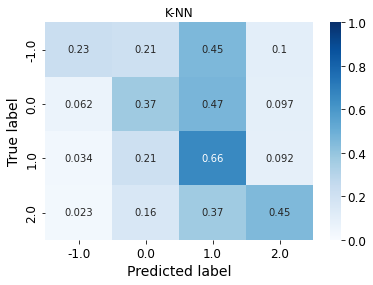

In [79]:
plot_confusion_matrix(knn, 'K-NN', y_knn_train_pred)

From the confusion matrix and the precision, recall, and f1 score we can see that the K-NN model is performing better than the random forest classifier. It is able to sucessfully classify the tweets from all categories, but performs best on the pro-climate change category. It also performs rather well on the anti-climate change and news categories.


### Linear SVC model
SVM works by plotting each data point in n-dimensional space, n-being the number of features. The algorithm then tries to find boundary (called a hyperplane) that will separate the data points into classes.

SVMs are particularly well suited for classification of complex small- or medium-sized datasets and could be a good candidate for our problem definition.


In [80]:
# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = cross_val_predict(lsvc, X_train, y_train, cv=10)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear fa

In [81]:
evaluate_model(lsvc, y_train, y_pred_lsvc)

Model:  Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf', LinearSVC(class_weight='balanced', random_state=0))])
              precision    recall  f1-score   support

        -1.0       0.36      0.42      0.39      3206
         0.0       0.38      0.39      0.39      6133
         1.0       0.72      0.66      0.69     18448
         2.0       0.56      0.64      0.60      7367

    accuracy                           0.59     35154
   macro avg       0.51      0.53      0.52     35154
weighted avg       0.60      0.59      0.59     35154





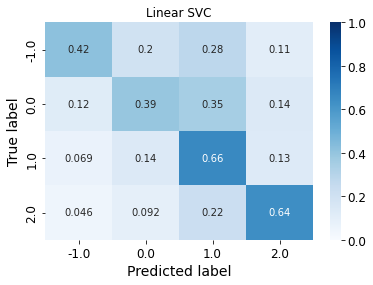

In [82]:
plot_confusion_matrix(lsvc, 'Linear SVC', y_pred_lsvc)

As can be seen by the confusion matrix and the precision, recall, and f1 score, the Linear SVC model performs better than the K-NN model. It is able to successfully classify the tweets from all categories, but performs best on the pro-climate change and news categories. It also performs decently on the anti-climate category.


## Hyperparameter tuning

Having found that the Linear SVC model is the best performing model we will move on with it and perform hyperparameter tuning in order to fine tune the model. Since we are using a larger hyperparameter space, we will use a random search to find the best hyperparameters.

For the hyperparamters we are dealing with two levels of tuning:

1. The first level is the tuning of the hyperparameters for the TFIDF transformer.
2. The second level is the tuning of the hyperparameters of the  Linear SVC model.

For the TFIDF we are using the following hyperparameters:

tfidf__ngram_range: The range of n-grams to consider when building the vocabulary.
min_df: The minimum number of documents a term must appear in to be included in the vocabulary.
max_df: The maximum fraction of documents a term can appear in to be included in the vocabulary.

For the Linear SVC we are using the following hyperparameters:

clf__C: Regularization parameter. A trade between decision boundary and classifying the training points correctly.
clf__max_iter: Maximum number of iterations.
max_features: The number of features to consider when looking for the best split.

In [83]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
param_grid = [{'clf__C': [i for i in np.arange(0.1, 0.6, 0.1)],
              'clf__max_iter': [1500, 2000, 2500, 3000, 4000],
              'tfidf__vec__ngram_range' : [(1,1),(1,2), (1,3)],
              #'tfidf__vec__min_df': [2, 3, 4],
              #'tfidf__vec__max_df': [0.8, 0.9]},
              "tfidf__vec__max_features": [i for i in np.arange(1, 5000, 5)]
               },

              {
               'clf__C': [i for i in np.arange(0.1, 0.6, 0.1)],
               'clf__max_iter': [1500, 2000, 2500, 3000, 4000],
               'tfidf__vec__ngram_range' : [(1,1),(1,2), (1,3)],
               'tfidf__vec__min_df': [2, 3, 4],
               'tfidf__vec__max_df': [0.8, 0.9],
               "tfidf__vec__max_features": [i for i in np.arange(5, 100, 2)]},

              {'clf__C': [i for i in np.arange(0.1, 0.6, 0.1)],
               'clf__max_iter': [1500, 2000, 2500, 3000, 4000],
               'tfidf__vec__ngram_range' : [(1,1),(1,2), (1,3)],
               'tfidf__vec__min_df': [2, 3, 4],
               'tfidf__vec__max_df': [i for i in np.arange(0.5, 1, 0.1)],
               "tfidf__vec__max_features": [i for i in np.arange(1, 5000, 5)]},
  ]


svc_mod = LinearSVC(random_state=0)

# Use randomized search to find the best hyperparameters due to Grid search being slow on hardware. Using macro to try to account for some of the label imbalance.
random_search = RandomizedSearchCV(lsvc, param_grid, cv=10,
                           scoring='f1_macro',
                           return_train_score=True,
                           n_jobs= -1)

random_search.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear fa

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('tfidf',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('vec',
                                                                               TfidfVectorizer(stop_words='english'),
                                                                               'message')])),
                                             ('scaler',
                                              StandardScaler(with_mean=False)),
                                             ('clf',
                                              LinearSVC(class_weight='balanced',
                                                        random_state=0))]),
                   n_jobs=-1,
                   param_distributions=[{'clf__C': [0.1, 0.2,
                                                    0.30000000000000004, 0....
               

In [84]:
random_search.best_estimator_

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_df=0.7,
                                                                  max_features=4696,
                                                                  min_df=4,
                                                                  stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 LinearSVC(C=0.1, class_weight='balanced', max_iter=4000,
                           random_state=0))])

In [85]:
# Training model using the best parameters
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_df=0.7,
                                                                  max_features=4696,
                                                                  min_df=4,
                                                                  stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 LinearSVC(C=0.1, class_weight='balanced', max_iter=4000,
                           random_state=0))])

In [86]:
y_pred = best_model.predict(X_test)

In [87]:
evaluate_model(best_model, y_test, y_pred)

Model:  Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vec',
                                                  TfidfVectorizer(max_df=0.7,
                                                                  max_features=4696,
                                                                  min_df=4,
                                                                  stop_words='english'),
                                                  'message')])),
                ('scaler', StandardScaler(with_mean=False)),
                ('clf',
                 LinearSVC(C=0.1, class_weight='balanced', max_iter=4000,
                           random_state=0))])
              precision    recall  f1-score   support

        -1.0       0.43      0.54      0.48       784
         0.0       0.50      0.52      0.51      1582
         1.0       0.79      0.71      0.75      4514
         2.0       0.66      0.72 

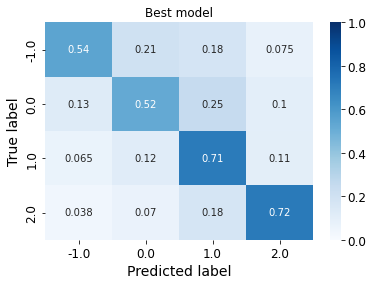

In [88]:
plot_confusion_matrix(best_model, "Best model", y_pred, y_true=y_test)

In [89]:
accuracy_score(y_pred, y_test)

0.6645807259073843

In [90]:
print('F1 score improved by',
      round(100*((accuracy_score(y_pred, y_test) - accuracy_score(y_pred_lsvc, y_train)) / accuracy_score(y_pred_lsvc, y_train)),0),
      '%')

F1 score improved by 13.0 %


After fine tuning our model we can see that the F1 score increased by about 14%. We could improve the model further by adjusting more of the hyperparamters and running a CVGridSearch.

Another possible improvement would be to try a different model, such as a neural network, to classify the tweets, as well as further feature engineering.

# Testing on new tweets

Initially we tried to use the labelled dataset to classify our new tweets, but the clustering did not work out. In order to not waste the entire dataset we therefore manually classified around 2000 tweets for an additional test of our model.

In [91]:
sheet_id = '18wO95Zh15uPcXjIKRVTlKQAUZBJzBYTVdZsEl3O7Mwo'
sheet_name = 'unlabeled_cleaned_sample'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

new_tweets = pd.read_csv(url, dtype={'message': str, 'id': 'str', 'tweets_sentiment':  'Int64'})

In [92]:
print(new_tweets.head())
print(new_tweets.shape)

                    id                                            message  \
0  1493879484147195904  RT @unescoEARTH: Are you able to demonstrate t...   
1  1493879570684076039  RT @FikreJesus: 🇪🇷leaving no one behind means ...   
2  1493886919679397890  accessing education.\nOur goal at JEF is to en...   
3  1493887055994277889  RT @nabileid1: A6 #AI and #ML are rapidly chan...   
4  1493887244242927622  #LDCs' trade over the past decade w focus on t...   

   sentiment  
0        2.0  
1        2.0  
2        2.0  
3        2.0  
4        2.0  
(1983, 3)


## A brief analysis of the new tweets

In order to get a better understanding of the new tweets we will do a quick analysis of the distributions of the tweets.

In [93]:
# Create a new df for analysis
df = new_tweets.copy()

df["sentiment"] = df["sentiment"].map(label_dict)

df["sentiment"].value_counts(normalize=True)

Neutral    0.520638
Pro        0.238855
News       0.168960
Anti       0.071547
Name: sentiment, dtype: float64

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


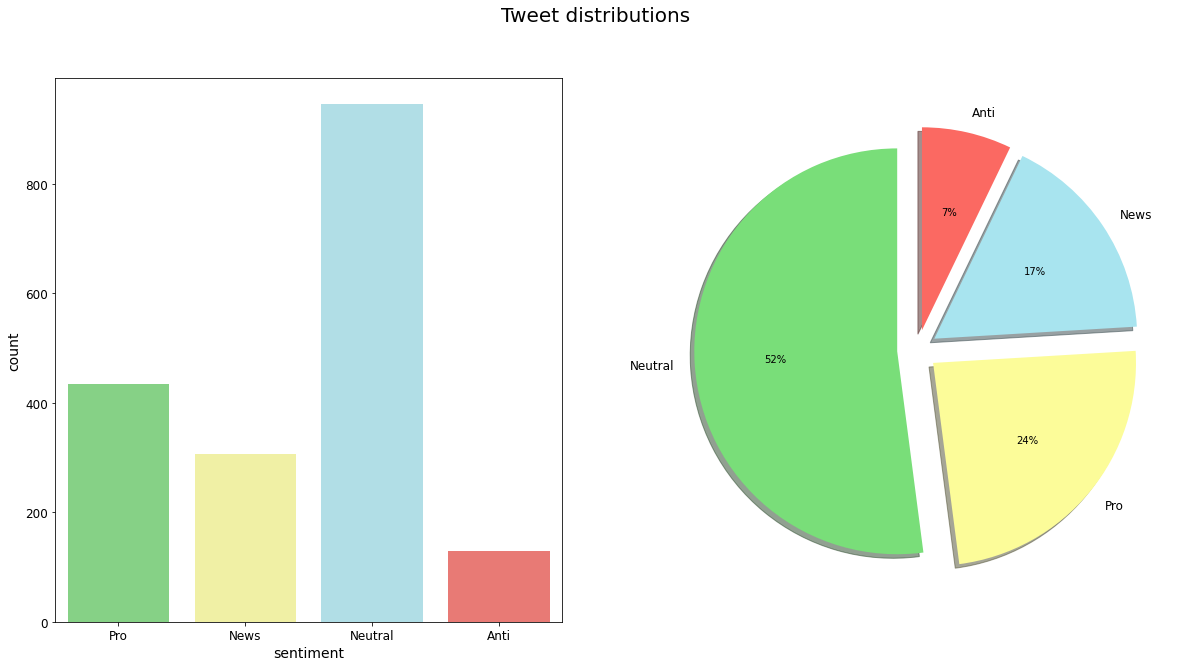

In [94]:
plot_target_dist(df["sentiment"])

We see that compared to the labelled dataset, the new tweets are more neutral. This could of course be due to the fact that our labelling was rather rudimentary and not based on a specific schema. Furthermore, our tweets were gathered in a rather limited timepsan, so it could be that the tweets are not very representative of the overall converstaion around climate change. That being said, we will move on to fit our model to the new tweets and see how it performs.

## Testing the model on new tweets
After a brief overview of our new tweets, we will now test our model's ability to predict the new tweets and evaluate our models performance.

In [95]:
# Merge with unlabelled_clean to get features
test_new_tweets = new_tweets.merge(unlabelled_cleaned, how='inner', on='id')

# Drop duplicates from merge
drop_cols = [col for col in test_new_tweets.columns if col.endswith('_y')]
test_new_tweets = test_new_tweets.drop(drop_cols, axis=1)
test_new_tweets.columns = [col.replace('_x', '') for col in test_new_tweets.columns]

# Drop missing values
test_new_tweets.dropna(inplace=True)

In [96]:
# Create features
new_tweets["message"] = new_tweets["message"].apply(TweetCleaner)
features = test_new_tweets.select_dtypes(include=['number']).drop(["sentiment"], axis=1).columns.to_list()
features.append('message')

# Split into X and y
new_x = test_new_tweets[features]
new_y = test_new_tweets['sentiment'].reset_index(drop=True)
test_new_tweets.shape

(1302, 36)

In [97]:
new_tweets_pred = best_model.predict(new_x)

In [98]:
print(classification_report(new_y, new_tweets_pred))

              precision    recall  f1-score   support

        -1.0       0.11      0.15      0.13        78
         0.0       0.63      0.30      0.40       660
         1.0       0.28      0.71      0.40       316
         2.0       0.46      0.15      0.22       248

    accuracy                           0.36      1302
   macro avg       0.37      0.33      0.29      1302
weighted avg       0.48      0.36      0.35      1302



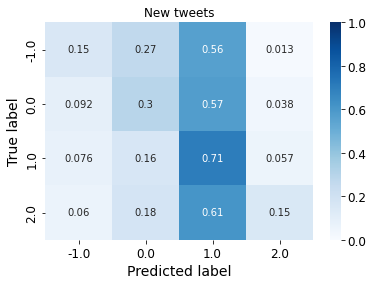

In [99]:
plot_confusion_matrix(best_model, "New tweets", new_tweets_pred, y_true=new_y)

After running our model on the new tweets we see that the models performance is rather poor. It performs a lot worse than on the test data and is not that good at predicting the new tweets. This could be due to many reasons, such as there being a time gap of several years between the labelled dataset and our new tweets. Furthermore, it could be the case that our model simply is not able to generalize very well to outside data. This could be to the chosen models capturing the data well enough, not enough data, or that the features included do not represent the data well.

## Conclusion


In this project we have used a combination of different machine learning models to classify tweets as being pro, against, neutral or news about climate change. We started by using the [Kaggle: Twitter Climate Change Sentiment Dataset](https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset) dataset that contained around 45k labelled tweets. We then collected around 100k new tweets containing terms or hashtags related to climate change.

After gathering the tweets we collected metadata about the tweets for both the labelled and unlabelled datasets. Furthermore we cleaned the data removing columns with too many missing values as well as transformed some columns into binary features.

We then moved on to trying to use clustering to label the unlabelled tweets using KMeans, but this did not provide a viable result.

After gathering, cleaning and attempting to cluster our data we performed an exploratory analysis of the labelled data showing that most tweets during the period of collection of the labelled tweets (Between Feb 2015 and Feb 2018) were labelled as pro climate change or news. There also appeared to be a strong political influence of the label of the tweets with Donald Trump being mentioned many times in anti-climate tweets and Bernie Sanders being mentioned many times in pro climate change tweets. This makes sense since the period covers a heated election in the US.

Finally we trained 3 a Random Forest model, a KNN model, and Linear SVC model on the labelled dataset using the following features:

- 'retweet_count'
- 'reply_count'
- 'like_count'
- 'quote_count
- 'in_reply_to_user'
- 'message'

Among the models the Linear SVC model performed the best with a f1 score of 0.59. After tuning the hyperparameters we were able to tweak the model to increase the performance by 2%.

Finally, we tested the model on a sample of the new tweets that we labelled ourselves, and found that the model performed poorly. This could be due to the model not being able to generalize well to outside data, the chosen models not capturing the data well enough, lack of data data, or that the features included do not represent the data well.

We started out trying to answer the following questions:

1. **Is there a temporal trend in climate change awareness?**
2. **Can we use sentiment analysis to get a general level of sentiment of climate change on Twitter?**

Since our model did not perform as well as desired on the new tweets, it is difficult to answer any of the initial questions. However, based on the exploratory analysis there could have been a change in the genral sentiment of climate change on Twitter moving towards being more neutral. Keeping in mind that our labelling was not rigorous, and the limited time span of data collection, it could be interesting to move forward and see if this could be the case by gathering more data, doing more feature engineering, and training more models. Neural Networks could be a promising type of models to explore.


# Topic Modeling

In [100]:
# copy dataframe

tm = joined.copy()

Create function to clean emoji and url from the tweet

In [101]:
# source: https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2

def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

In [102]:
tm['emoji_free_tweets'] = tm['message'].apply(lambda x: give_emoji_free_text(x))
tm['url_free_tweets'] = tm['emoji_free_tweets'].apply(url_free_text)

Next, we need to convert sentences into words, convert words into their root and removing words that are too common or too irrelevant to topic modeling. We will use these techniques:
* **Tokenization**: split text into sentences and then words. lower case the text and remove punctuation
* remove any words that mentioned less than 3 times
* All **stopwords** are removed
* **Lemmatized** and stemmed all words

In [103]:
nlp = spacy.load('en_core_web_lg')

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/catalogue/__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use s

In [104]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(tm['url_free_tweets'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
tm['tokens'] = tokens

In [105]:
# Make tokens a string again
tm['tokens_back_to_text'] = [' '.join(map(str, l)) for l in tm['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

tm['lemmas'] = tm['tokens_back_to_text'].apply(get_lemmas)

In [106]:
# Make lemmas a string again
tm['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in tm['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
tm['lemma_tokens'] = tm['lemmas_back_to_text'].apply(tokenize)

<>:19: DeprecationWarning: invalid escape sequence '\w'
<>:20: DeprecationWarning: invalid escape sequence '\$'
<>:19: DeprecationWarning: invalid escape sequence '\w'
<>:20: DeprecationWarning: invalid escape sequence '\$'
/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_1816/1885253480.py:19: DeprecationWarning: invalid escape sequence '\w'
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
/var/folders/qr/9gxl11ls35j2b_08fgngvnmw0000gn/T/ipykernel_1816/1885253480.py:20: DeprecationWarning: invalid escape sequence '\$'
  tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $


Remove Retweet before fitting a model

In [125]:
tm = tm[~tm['lemma_tokens'].apply(lambda x: True if 'rt' in x else False)]

Now, we produce a base model first to track our progress as we go through the hyper-parameter tuning.

In [126]:
#create a id2word dictionary
id2word = Dictionary(tm['lemma_tokens'])
print(len(id2word))

90998


In [127]:
# filtering extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

33058


In [128]:
# Create corpus obj
corpus = [id2word.doc2bow(d) for d in tm['lemma_tokens']]

In [129]:
# instantiate a base lda model
base_model = LdaMulticore(corpus= corpus, num_topics= 5, id2word=id2word, workers=12, passes=5)

In [130]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [131]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [132]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
climate change people potus trump environment think need world right

------ Topic 1 ------
global warming climate environment change green people need year know

------ Topic 2 ------
sustainable green environment climate sustainability ️ nature climatechange day energy

------ Topic 3 ------
climate environment change new work energy green potus ️ help

------ Topic 4 ------
sustainable etsy green climate rediscova vintage art gift tableware antique



Let's check Model perplexity and topic coherence to judge how good a given topic model is.

In [134]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=tm['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -8.349843894209672

Coherence Score:  0.2671802764047778


In [136]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/past/builtin

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.129014  0.044650       1        1  31.097528
3      0.037274 -0.003381       2        1  19.457227
1      0.067273 -0.035830       3        1  18.671796
2     -0.095676 -0.094153       4        1  17.575560
4     -0.137884  0.088714       5        1  13.197890, topic_info=              Term          Freq         Total Category  logprob  loglift
524    sustainable   6490.000000   6490.000000  Default  30.0000  30.0000
2           change  17508.000000  17508.000000  Default  29.0000  29.0000
4           global   5195.000000   5195.000000  Default  28.0000  28.0000
11         warming   3974.000000   3974.000000  Default  27.0000  27.0000
3          climate  26631.000000  26631.000000  Default  26.0000  26.0000
..             ...           ...           ...      ...      ...      ...
521         energy    430.471969   3430.581985   Topic5  -5.5836  -0.0505
480          thank    329.097126   1367.385448   Topic5  -5.8521   0.6008
390  climatechange    352.954558   2069.483945   Topic5  -5.7821   0.2564
214           year    337.827594   2522.466552   Topic5  -5.8260   0.0147
2           change    408.412256  17508.741563   Topic5  -5.6362  -1.7331

[469 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
18765      1  0.977204    0.0
18765      2  0.003453    0.0
18765      5  0.017265    0.0
13698      1  0.019161  1,200
13698      2  0.862240  1,200
...      ...       ...    ...
5902       3  0.019950      🤣
5902       4  0.612758      🤣
5902       5  0.022800      🤣
13881      3  0.039516      🤮
13881      5  0.948390      🤮

[1386 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3, 5])

The bubble on the left-hand side plot represent a topics. The larger it is the more prevalent it is. A good topic model will have big non-overlapping bubbles.

If we hangover the bubble on the left the right-hand side plot represent words which is salient keywords that form the selected topic.

## Grid Search

We will tuning a `n_componennts`, which is number of topics, and `learning_decay`, a learning rate.

In [138]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(tm['lemmas_back_to_text'])

In [140]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             n_jobs=-1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [141]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -2077095.245387278
Model Perplexity:  6396.709395473504


## Optimum number of topics

In [142]:
#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic    

In [144]:
# Can take a long time to run.
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=tm['lemma_tokens'],
                                                        start=2, limit=200, step=6)

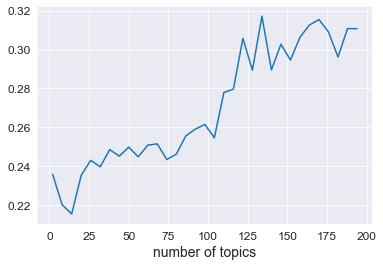

In [188]:
sns.set_style('darkgrid')
sns.lineplot(x= [x.num_topics for x in model_list_topic], y=coherence_values_topic)
plt.xlabel('number of topics')
plt.show()

In [189]:
final_model= model_list_topic[19]

In [190]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(final_model, corpus, id2word)

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/google-colab/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecat

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
56     0.195185  0.113767       1        1  2.013022
17    -0.089950  0.088384       2        1  1.544253
113   -0.078834  0.062384       3        1  1.348663
33    -0.034199  0.082286       4        1  1.334562
80    -0.054534 -0.002631       5        1  1.269816
...         ...       ...     ...      ...       ...
59     0.086089 -0.111236     112        1  0.572034
39     0.016321 -0.021684     113        1  0.543740
3      0.082952  0.014755     114        1  0.523942
50     0.066116  0.037639     115        1  0.516351
84     0.112232 -0.025457     116        1  0.514083

[116 rows x 5 columns], topic_info=              Term          Freq         Total  Category  logprob  loglift
22183    rediscova   2720.000000   2720.000000   Default  30.0000  30.0000
290          potus   2092.000000   2092.000000   Default  29.0000  29.0000
6645             �   1362.000000   1362.000000   Default  28.0000  28.0000
12462         etsy   3696.000000   3696.000000   Default  27.0000  27.0000
723          green  10893.000000  10893.000000   Default  26.0000  26.0000
...            ...           ...           ...       ...      ...      ...
167    environment     19.571786   6912.145881  Topic116  -5.4290  -0.5964
2           change     20.916102  13894.347148  Topic116  -5.3625  -1.2282
537           late     14.328854   1166.860344  Topic116  -5.7408   0.8707
1583         learn     13.723617   1144.436672  Topic116  -5.7839   0.8470
214           year     14.677051   2373.193989  Topic116  -5.7168   0.1848

[9275 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
623       51  0.636852  'bout
816        1  0.011700      +
816        2  0.007020      +
816        3  0.016381      +
816        4  0.007020      +
...      ...       ...    ...
24320    114  0.732546      🦏
13758     51  0.625773      🧪
13758     98  0.156443      🧪
23509     44  0.177502      🪄
23509     93  0.532507      🪄

[83364 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[57, 18, 114, 34, 81, 15, 5, 87, 49, 72, 53, 50, 92, 32, 28, 79, 29, 2, 1, 75, 89, 48, 108, 54, 41, 19, 67, 71, 24, 111, 104, 100, 43, 58, 37, 3, 103, 113, 35, 33, 82, 30, 12, 9, 38, 27, 109, 21, 80, 116, 10, 25, 90, 98, 36, 45, 65, 70, 68, 8, 52, 88, 13, 46, 76, 17, 7, 94, 22, 102, 47, 23, 78, 69, 99, 101, 64, 6, 86, 63, 106, 74, 66, 31, 16, 73, 56, 77, 11, 14, 91, 105, 39, 110, 115, 59, 44, 61, 83, 96, 112, 107, 84, 26, 97, 62, 42, 93, 55, 95, 20, 60, 40, 4, 51, 85])

## References

Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition (2019). Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. [online] O’Reilly | Safari. Available at: https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/.

https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset

https://www.kaggle.com/nicolemeinie/sentiment-analysis-twitter-on-climate-change

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://stackoverflow.com/questions/67768470/valueerror-found-input-variables-with-inconsistent-numbers-of-samples-6-80

https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2
